Importación de librerías

In [25]:
#!pip show pycaret

In [14]:
#!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Using cached pycaret-3.3.2-py3-none-any.whl.metadata (17 kB)
  Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
Using cached pycaret-3.3.2-py3-none-any.whl (486 kB)

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [5]:
#!pip install tensorflow tensorflow-datasets

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
import zipfile
import clip
import json
import glob
import random
import shutil
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
import tensorflow_datasets as tfds
import tensorflow as tf

from torchvision import transforms
from PIL import Image
from tqdm.notebook import tqdm
from pathlib import Path
from pycaret.classification import *
from transformers import AutoModel, AutoProcessor
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from transformers import AutoModelForZeroShotImageClassification

2025-10-03 14:59:35.020667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759503575.036396   28515 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759503575.041419   28515 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759503575.054080   28515 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759503575.054095   28515 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759503575.054097   28515 computation_placer.cc:177] computation placer alr

Instalar PyTorch y torchvision

In [6]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install timm torchvision
!pip install xformers

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [39]:
# zip_path = "NABirds.zip"
# output_folder = "datasets"

# os.makedirs(output_folder, exist_ok=True)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(output_folder)

print("Archivo extraído correctamente.")

Archivo extraído correctamente.


In [43]:
# Ruta base de tu dataset
base_path = Path("datasets/NABirds/dataset")

# Subdirectorios
splits = ['train', 'test', 'validation']

# Contadores
total_images = 0
split_counts = {}

# Contar imágenes
for split in splits:
    split_path = base_path / split
    image_count = sum(
        1 for ext in ('*.png', '*.jpg', '*.jpeg') 
        for _ in split_path.rglob(ext)
    )
    split_counts[split] = image_count
    total_images += image_count

# Mostrar resultados
for split, count in split_counts.items():
    print(f"Total de imágenes en {split}: {count}")

print(f"\nTotal general de imágenes: {total_images}")

Total de imágenes en train: 19301
Total de imágenes en test: 24615
Total de imágenes en validation: 4611

Total general de imágenes: 48527


In [54]:
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers
!pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vs3bujvt
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vs3bujvt
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


Definición de datasets

In [3]:
BASE_DATASETS_DIR = "datasets"

datasets_to_process = [
    {
        'name': 'NABirds',
        'base_folder_in_datasets_dir': 'NABirds',
        'sub_dataset_folder': 'dataset',
        'subsets_map': {
            'train': 'train',
            'test': 'test',
            'validation': 'validation'
        }
    },
    {
        'name': 'CUB_200_2011',
        'base_folder_in_datasets_dir': 'CUB_200_2011',
        'sub_dataset_folder': 'dataset',
        'subsets_map': {
            'train': 'train',
            'test': 'test',
            'validation': 'validation'
        }
    },
    {
        'name': 'FGVC-Aircraft',
        'base_folder_in_datasets_dir': 'FGVC-Aircraft',
        'sub_dataset_folder': 'dataset',
        'subsets_map': {
            'train': 'train',
            'test': 'test',
            'validation': 'validation'
        }
    },
    {
        'name': 'Oxford 102 Flower',
        'base_folder_in_datasets_dir': 'Oxford 102 flower',
        'sub_dataset_folder': 'dataset',
        'subsets_map': {
            'train': 'train',
            'test': 'test',
            'validation': 'validation'
        }
    },
    {
        'name': 'Stanford Cars',
        'base_folder_in_datasets_dir': 'Stanford Cars',
        'sub_dataset_folder': 'dataset',
        'subsets_map': {
            'train': 'train',
            'test': 'test',
            'validation': 'validation'
        }
    },
    {
        'name': 'Stanford Dogs',
        'base_folder_in_datasets_dir': 'Stanford Dogs',
        'sub_dataset_folder': 'dataset',
        'subsets_map': {
            'train': 'train',
            'test': 'test',
            'validation': 'validation'
        }
    }
]

def get_image_paths_and_labels(base_path_to_data_folder):
    image_data = []
    if not os.path.exists(base_path_to_data_folder):
        print(f"Warning: Directory does not exist, skipping: {base_path_to_data_folder}")
        return []
    for root, _, files in os.walk(base_path_to_data_folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_image_path = os.path.join(root, file)
                rel_path = os.path.relpath(full_image_path, base_path_to_data_folder)
                parts = rel_path.split(os.sep)
                label = os.path.join(*parts[:-1]) if len(parts) >= 2 else "unknown"
                image_data.append({'image_path': full_image_path, 'label': label})
    return image_data

In [ ]:
Cargar datasets

In [4]:
all_datasets_info = {}

for dataset_config in datasets_to_process:
    dataset_name = dataset_config['name']
    base_folder = dataset_config['base_folder_in_datasets_dir']
    sub_dataset_folder = dataset_config['sub_dataset_folder']
    subsets_map = dataset_config['subsets_map']

    current_dataset_root = os.path.join(BASE_DATASETS_DIR, base_folder)
    if sub_dataset_folder:
        current_dataset_root = os.path.join(current_dataset_root, sub_dataset_folder)
    if not os.path.exists(current_dataset_root):
        print(f"Dataset root not found: {current_dataset_root}")
        continue

    all_datasets_info[dataset_name] = {}
    for standard_subset_name, actual_folder_name in subsets_map.items():
        subset_path = os.path.join(current_dataset_root, actual_folder_name)
        images_info = get_image_paths_and_labels(subset_path)
        all_datasets_info[dataset_name][standard_subset_name] = images_info
        print(f"{dataset_name} - {standard_subset_name}: {len(images_info)} images")

NABirds - train: 19314 images
NABirds - test: 24633 images
NABirds - validation: 4615 images
CUB_200_2011 - train: 4800 images
CUB_200_2011 - test: 5794 images
CUB_200_2011 - validation: 1194 images
FGVC-Aircraft - train: 3334 images
FGVC-Aircraft - test: 3333 images
FGVC-Aircraft - validation: 3333 images
Oxford 102 Flower - train: 6149 images
Oxford 102 Flower - test: 1020 images
Oxford 102 Flower - validation: 1020 images
Stanford Cars - train: 6598 images
Stanford Cars - test: 8041 images
Stanford Cars - validation: 1546 images
Stanford Dogs - train: 9600 images
Stanford Dogs - test: 8580 images
Stanford Dogs - validation: 2400 images


Configurar modelos

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_configs = {
    'FRANCA': {
        'loader': lambda: torch.hub.load(
            'valeoai/Franca',
            'franca_vitb14',  # o franca_vitg14, franca_vitl14
            trust_repo=True
        ).eval(),
        'transform': transforms.Compose([
            transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                 std=(0.229, 0.224, 0.225)),
        ])
    },
    'DINOv2': {
        'loader': lambda: torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').eval(),
        'transform': transforms.Compose([
            transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                 std=(0.229, 0.224, 0.225)),
        ])
    },
    'CLIP': {
        'loader': lambda: clip.load("ViT-B/32", device=device)[0].eval(),
        'transform': clip.load("ViT-B/32", device=device)[1]
    },
    'SigLIPv2': {
        'loader': lambda: AutoModelForZeroShotImageClassification.from_pretrained("google/siglip2-base-patch16-256").eval(),
        'transform': AutoProcessor.from_pretrained("google/siglip2-base-patch16-256")
    }
}

Using device: cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Funcion extracción de embeddings

In [6]:
def extract_embeddings_batch(image_list, model, transform, model_name, batch_size=64):
    extracted = []
    if not image_list or model is None:
        return extracted

    for i in tqdm(range(0, len(image_list), batch_size), desc=f"{model_name} embeddings"):
        batch = image_list[i:i+batch_size]
        imgs, paths, labels = [], [], []

        for item in batch:
            try:
                img = Image.open(item['image_path']).convert('RGB')
                if model_name == 'SigLIPv2':
                    proc = transform(images=img, return_tensors='pt')
                    imgs.append(proc['pixel_values'])
                else:
                    imgs.append(transform(img).unsqueeze(0))
                paths.append(item['image_path'])
                labels.append(item['label'])
            except Exception as e:
                print(f"Error loading {item['image_path']}: {e}")
                continue

        if not imgs:
            continue

        batch_tensor = torch.cat(imgs, dim=0).to(device)
        with torch.no_grad():
            if model_name == 'CLIP':
                emb = model.encode_image(batch_tensor)
            elif model_name == 'SigLIPv2':
                emb = model.get_image_features(batch_tensor)
            else:
                feats = model.forward_features(batch_tensor) if hasattr(model, 'forward_features') else model(batch_tensor)
                if isinstance(feats, torch.Tensor):
                    emb = feats
                elif isinstance(feats, dict) and 'x_norm_clstoken' in feats:
                    emb = feats['x_norm_clstoken']
                else:
                    emb = list(feats.values())[0]
            emb_np = emb.cpu().numpy()

        for j, p in enumerate(paths):
            extracted.append({'image_path': p, 'label': labels[j], 'embedding': emb_np[j]})

    return extracted

Bucle de extracción

In [7]:
# OUTPUT_DIR = "embeddings"
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# # Seleccionar solo el modelo SigLIPv2
# name = "SigLIPv2"
# cfg = model_configs[name]

# print(f"\n=== Processing model: {name} ===")
# model = cfg['loader']().to(device)
# transform_fn = cfg['transform']

# # Carpeta del modelo
# model_out = os.path.join(OUTPUT_DIR, name)
# os.makedirs(model_out, exist_ok=True)

# for dataset_name, subsets in all_datasets_info.items():
#     # Carpeta del dataset dentro del modelo
#     dataset_out_dir = os.path.join(model_out, dataset_name)
#     os.makedirs(dataset_out_dir, exist_ok=True)

#     for subset, img_list in subsets.items():
#         if not img_list:
#             continue
#         print(f" * {dataset_name} - {subset} ({len(img_list)} images)")
#         data = extract_embeddings_batch(img_list, model, transform_fn, name)

#         if not data:
#             continue

#         df_meta = pd.DataFrame(
#             [{'image_path': it['image_path'], 'label': it['label']} for it in data]
#         )
#         emb_arr = np.array([it['embedding'] for it in data])
#         df_emb = pd.DataFrame(emb_arr, columns=[f"dim_{i}" for i in range(emb_arr.shape[1])])
#         df = pd.concat([df_meta, df_emb], axis=1)

#         # Guardar como subset_embeddings.parquet
#         fname = f"{subset}_embeddings.parquet"
#         df.to_parquet(os.path.join(dataset_out_dir, fname), index=False)
#         print(f"   Saved: {os.path.join(dataset_out_dir, fname)} — shape {df.shape}")

# print("\nSigLIPv2 processed successfully!")



=== Processing model: SigLIPv2 ===
 * NABirds - train (19314 images)


SigLIPv2 embeddings:   0%|          | 0/302 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/NABirds/train_embeddings.parquet — shape (19314, 770)
 * NABirds - test (24633 images)


SigLIPv2 embeddings:   0%|          | 0/385 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/NABirds/test_embeddings.parquet — shape (24633, 770)
 * NABirds - validation (4615 images)


SigLIPv2 embeddings:   0%|          | 0/73 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/NABirds/validation_embeddings.parquet — shape (4615, 770)
 * CUB_200_2011 - train (4800 images)


SigLIPv2 embeddings:   0%|          | 0/75 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/CUB_200_2011/train_embeddings.parquet — shape (4800, 770)
 * CUB_200_2011 - test (5794 images)


SigLIPv2 embeddings:   0%|          | 0/91 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/CUB_200_2011/test_embeddings.parquet — shape (5794, 770)
 * CUB_200_2011 - validation (1194 images)


SigLIPv2 embeddings:   0%|          | 0/19 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/CUB_200_2011/validation_embeddings.parquet — shape (1194, 770)
 * FGVC-Aircraft - train (3334 images)


SigLIPv2 embeddings:   0%|          | 0/53 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/FGVC-Aircraft/train_embeddings.parquet — shape (3334, 770)
 * FGVC-Aircraft - test (3333 images)


SigLIPv2 embeddings:   0%|          | 0/53 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/FGVC-Aircraft/test_embeddings.parquet — shape (3333, 770)
 * FGVC-Aircraft - validation (3333 images)


SigLIPv2 embeddings:   0%|          | 0/53 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/FGVC-Aircraft/validation_embeddings.parquet — shape (3333, 770)
 * Oxford 102 Flower - train (6149 images)


SigLIPv2 embeddings:   0%|          | 0/97 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/Oxford 102 Flower/train_embeddings.parquet — shape (6149, 770)
 * Oxford 102 Flower - test (1020 images)


SigLIPv2 embeddings:   0%|          | 0/16 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/Oxford 102 Flower/test_embeddings.parquet — shape (1020, 770)
 * Oxford 102 Flower - validation (1020 images)


SigLIPv2 embeddings:   0%|          | 0/16 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/Oxford 102 Flower/validation_embeddings.parquet — shape (1020, 770)
 * Stanford Cars - train (6598 images)


SigLIPv2 embeddings:   0%|          | 0/104 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/Stanford Cars/train_embeddings.parquet — shape (6598, 770)
 * Stanford Cars - test (8041 images)


SigLIPv2 embeddings:   0%|          | 0/126 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/Stanford Cars/test_embeddings.parquet — shape (8041, 770)
 * Stanford Cars - validation (1546 images)


SigLIPv2 embeddings:   0%|          | 0/25 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/Stanford Cars/validation_embeddings.parquet — shape (1546, 770)
 * Stanford Dogs - train (9600 images)


SigLIPv2 embeddings:   0%|          | 0/150 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/Stanford Dogs/train_embeddings.parquet — shape (9600, 770)
 * Stanford Dogs - test (8580 images)


SigLIPv2 embeddings:   0%|          | 0/135 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/Stanford Dogs/test_embeddings.parquet — shape (8580, 770)
 * Stanford Dogs - validation (2400 images)


SigLIPv2 embeddings:   0%|          | 0/38 [00:00<?, ?it/s]

   Saved: embeddings/SigLIPv2/Stanford Dogs/validation_embeddings.parquet — shape (2400, 770)

SigLIPv2 processed successfully!


In [7]:
OUTPUT_DIR = "embeddings"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for name, cfg in model_configs.items():
    print(f"\n=== Processing model: {name} ===")
    model = cfg['loader']().to(device)
    transform_fn = cfg['transform']

    # Carpeta del modelo
    model_out = os.path.join(OUTPUT_DIR, name)
    os.makedirs(model_out, exist_ok=True)

    for dataset_name, subsets in all_datasets_info.items():
        # Carpeta del dataset dentro del modelo
        dataset_out_dir = os.path.join(model_out, dataset_name)
        os.makedirs(dataset_out_dir, exist_ok=True)

        for subset, img_list in subsets.items():
            if not img_list:
                continue
            print(f" * {dataset_name} - {subset} ({len(img_list)} images)")
            data = extract_embeddings_batch(img_list, model, transform_fn, name)

            if not data:
                continue

            df_meta = pd.DataFrame(
                [{'image_path': it['image_path'], 'label': it['label']} for it in data]
            )
            emb_arr = np.array([it['embedding'] for it in data])
            df_emb = pd.DataFrame(emb_arr, columns=[f"dim_{i}" for i in range(emb_arr.shape[1])])
            df = pd.concat([df_meta, df_emb], axis=1)

            # Guardar como subset_embeddings.parquet
            fname = f"{subset}_embeddings.parquet"
            df.to_parquet(os.path.join(dataset_out_dir, fname), index=False)
            print(f"   Saved: {os.path.join(dataset_out_dir, fname)} — shape {df.shape}")

print("\nAll models processed successfully!")


=== Processing model: FRANCA ===


Using cache found in /home/jovyan/.cache/torch/hub/valeoai_Franca_main


 * NABirds - train (19314 images)


FRANCA embeddings:   0%|          | 0/302 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [2]:
# === Cargar todos los parquet en un diccionario usando os ===
root_dir = "embeddings"
dataframes = {}

for embedding in os.listdir(root_dir):
    embedding_path = os.path.join(root_dir, embedding)
    if os.path.isdir(embedding_path):
        for dataset in os.listdir(embedding_path):
            dataset_path = os.path.join(embedding_path, dataset)
            if os.path.isdir(dataset_path):
                for file in os.listdir(dataset_path):
                    if file.endswith(".parquet"):
                        split_name = file.replace("_embeddings.parquet", "")  # train, test, validation
                        key = (embedding, dataset, split_name)
                        dataframes[key] = pd.read_parquet(os.path.join(dataset_path, file))

# Verificamos que cargó algo
print("Ejemplo de keys en dataframes:", list(dataframes.keys())[:10])

Ejemplo de keys en dataframes: [('FRANCA', 'Stanford Dogs', 'test'), ('FRANCA', 'Stanford Dogs', 'train'), ('FRANCA', 'Stanford Dogs', 'validation'), ('FRANCA', 'Oxford 102 Flower', 'test'), ('FRANCA', 'Oxford 102 Flower', 'train'), ('FRANCA', 'Oxford 102 Flower', 'validation'), ('FRANCA', 'CUB_200_2011', 'test'), ('FRANCA', 'CUB_200_2011', 'train'), ('FRANCA', 'CUB_200_2011', 'validation'), ('FRANCA', 'FGVC-Aircraft', 'test')]


In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def entrenar_modelo(embedding, dataset, df_train, df_val, df_test):
    print(f"\n=== Entrenando modelo con embedding: {embedding}, dataset: {dataset} ===")
    print(f"Train: {df_train.shape}, Val: {df_val.shape}, Test: {df_test.shape}")

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test  = df_test.reset_index(drop=True)
    
    # Setup de PyCaret
    s1 = setup(
        df_train,
        test_data=df_val,
        target='label',
        session_id=123,
        index=False
    )

    # Comparación de modelos (sin cross-validation)
    best_no_bal = compare_models(
        include=['dummy', 'lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 
                 'mlp', 'ridge', 'rf', 'qda', 'ada', 'lda', 'et'],
        cross_validation=False
    )
    
    # Mostrar la tabla con todos los resultados
    resultados = pull()
    print("\nResultados de todos los modelos:")
    print(resultados)
    
    # Mostrar el mejor modelo
    print("\nMejor modelo encontrado:")
    print(best_no_bal)
    
    # Predicción en test
    predictions = predict_model(best_no_bal, data=df_test)
    
    # Matriz de confusión
    '''y_true = df_test['label']
    y_pred = predictions['prediction_label']
    
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalizada por filas
    
    # Si hay demasiadas clases, mostrar solo las top-N más frecuentes
    n_clases = len(np.unique(y_true))
    top_n = 20  # puedes ajustar
    
    if n_clases > top_n:
        # Seleccionar las top-N clases más frecuentes
        clases_frecuentes = y_true.value_counts().nlargest(top_n).index
        mask = [cls in clases_frecuentes for cls in np.unique(y_true)]
        
        cm_plot = cm_norm[mask][:, mask]
        labels_plot = np.unique(y_true)[mask]
    else:
        cm_plot = cm_norm
        labels_plot = np.unique(y_true)
    
    plt.figure(figsize=(12,10))
    sns.heatmap(cm_plot, annot=False, cmap="Blues", xticklabels=labels_plot, yticklabels=labels_plot)
    plt.title(f"Matriz de confusión normalizada ({embedding} - {dataset})")
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta real")
    plt.show()'''
    cm=None
    
    return best_no_bal, resultados, predictions, cm

In [4]:
# === Loop automático para entrenar todos los embeddings y datasets ===
# Detectamos automáticamente todos los embeddings y datasets
embeddings = sorted({key[0] for key in dataframes.keys()})
datasets = sorted({key[1] for key in dataframes.keys()})

for embedding in embeddings:
    print()
    for dataset in datasets:
        required_splits = ['train', 'validation', 'test']
        if all((embedding, dataset, split) in dataframes for split in required_splits):
            df_train = dataframes[(embedding, dataset, 'train')]
            df_val = dataframes[(embedding, dataset, 'validation')]
            df_test = dataframes[(embedding, dataset, 'test')]
            
            entrenar_modelo(embedding, dataset, df_train, df_val, df_test)
        else:
            print(f"Saltando {embedding} / {dataset}, faltan splits")



=== Entrenando modelo con embedding: CLIP, dataset: CUB_200_2011 ===
Train: (4800, 514), Val: (1194, 514), Test: (5794, 514)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7035  0.9950  0.7035  0.7319   
mlp                      MLP Classifier    0.6566  0.9930  0.6566  0.6855   
ridge                  Ridge Classifier    0.6441  0.0000  0.6441  0.6611   
rf             Random Forest Classifier    0.5402  0.9715  0.5402  0.5662   
et               Extra Trees Classifier    0.5327  0.9666  0.5327  0.5614   
svm                 SVM - Linear Kernel    0.2429  0.0000  0.2429  0.1680   
rbfsvm              SVM - Radial Kernel    0.1658  0.9718  0.1658  0.0886   
knn              K Neighbors Classifier    0.1608  0.6128  0.1608  0.0933   
nb                          Naive Bayes    0.0101  0.0000  0.0101  0.0001   
dummy                  Dummy Classifier    0.0050  0.0000  0.0050  0.0000   
dt             Decision Tree Classifier    0.0050  0.0000  0.0050  0.0000   
ada                Ada Boost Classifier   


=== Entrenando modelo con embedding: CLIP, dataset: FGVC-Aircraft ===
Train: (3334, 514), Val: (3333, 514), Test: (3333, 514)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
ridge                  Ridge Classifier    0.4191  0.0000  0.4191  0.3941   
lr                  Logistic Regression    0.4134  0.9572  0.4134  0.4364   
mlp                      MLP Classifier    0.3849  0.9560  0.3849  0.4058   
et               Extra Trees Classifier    0.3237  0.8947  0.3237  0.3213   
rf             Random Forest Classifier    0.3219  0.9043  0.3219  0.3222   
knn              K Neighbors Classifier    0.2214  0.6715  0.2214  0.2043   
svm                 SVM - Linear Kernel    0.1998  0.0000  0.1998  0.1896   
rbfsvm              SVM - Radial Kernel    0.1665  0.9150  0.1665  0.0990   
nb                          Naive Bayes    0.0114  0.0000  0.0114  0.0002   
dt             Decision Tree Classifier    0.0102  0.0000  0.0102  0.0001   
lda        Linear Discriminant Analysis    0.0102  0.0000  0.0102  0.0001   
dummy                  Dummy Classifier   


=== Entrenando modelo con embedding: CLIP, dataset: NABirds ===
Train: (19314, 514), Val: (4615, 514), Test: (24633, 514)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.6416  0.9968  0.6416  0.6689   
ridge                  Ridge Classifier    0.5304  0.0000  0.5304  0.5482   
mlp                      MLP Classifier    0.4869  0.9936  0.4869  0.5362   
et               Extra Trees Classifier    0.4531  0.9449  0.4531  0.4622   
rf             Random Forest Classifier    0.4522  0.9528  0.4522  0.4486   
knn              K Neighbors Classifier    0.0717  0.5473  0.0717  0.0242   
rbfsvm              SVM - Radial Kernel    0.0581  0.7325  0.0581  0.0153   
svm                 SVM - Linear Kernel    0.0030  0.0000  0.0030  0.0026   
dummy                  Dummy Classifier    0.0026  0.0000  0.0026  0.0000   
nb                          Naive Bayes    0.0026  0.0000  0.0026  0.0000   
dt             Decision Tree Classifier    0.0026  0.0000  0.0026  0.0000   
qda     Quadratic Discriminant Analysis   


=== Entrenando modelo con embedding: CLIP, dataset: Oxford 102 Flower ===
Train: (6149, 514), Val: (1020, 514), Test: (1020, 514)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
mlp                      MLP Classifier    0.9618  0.9995  0.9618  0.9646   
lr                  Logistic Regression    0.9539  0.9997  0.9539  0.9597   
ridge                  Ridge Classifier    0.8902  0.0000  0.8902  0.9160   
rf             Random Forest Classifier    0.8520  0.9951  0.8520  0.8941   
et               Extra Trees Classifier    0.8510  0.9963  0.8510  0.8838   
svm                 SVM - Linear Kernel    0.7608  0.0000  0.7608  0.7680   
knn              K Neighbors Classifier    0.5000  0.7879  0.5000  0.4321   
rbfsvm              SVM - Radial Kernel    0.4324  0.9961  0.4324  0.3296   
dt             Decision Tree Classifier    0.0794  0.5351  0.0794  0.0368   
dummy                  Dummy Classifier    0.0098  0.0000  0.0098  0.0001   
nb                          Naive Bayes    0.0098  0.0000  0.0098  0.0001   
qda     Quadratic Discriminant Analysis   


=== Entrenando modelo con embedding: CLIP, dataset: Stanford Cars ===
Train: (6598, 514), Val: (1546, 514), Test: (8041, 514)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7937  0.9981  0.7937  0.8076   
mlp                      MLP Classifier    0.7497  0.9976  0.7497  0.7714   
ridge                  Ridge Classifier    0.7193  0.0000  0.7193  0.7447   
rf             Random Forest Classifier    0.6074  0.9814  0.6074  0.6281   
et               Extra Trees Classifier    0.6067  0.9776  0.6067  0.6325   
svm                 SVM - Linear Kernel    0.2523  0.0000  0.2523  0.2193   
knn              K Neighbors Classifier    0.2031  0.6378  0.2031  0.1233   
rbfsvm              SVM - Radial Kernel    0.1669  0.9877  0.1669  0.0986   
dummy                  Dummy Classifier    0.0084  0.0000  0.0084  0.0001   
dt             Decision Tree Classifier    0.0084  0.0000  0.0084  0.0001   
ada                Ada Boost Classifier    0.0084  0.0000  0.0084  0.0001   
qda     Quadratic Discriminant Analysis   


=== Entrenando modelo con embedding: CLIP, dataset: Stanford Dogs ===
Train: (9600, 514), Val: (2400, 514), Test: (8580, 514)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.6988  0.9940  0.6988  0.7169   
mlp                      MLP Classifier    0.6712  0.9925  0.6712  0.6862   
ridge                  Ridge Classifier    0.6475  0.0000  0.6475  0.6722   
rf             Random Forest Classifier    0.5079  0.9524  0.5079  0.5175   
et               Extra Trees Classifier    0.4883  0.9462  0.4883  0.4874   
svm                 SVM - Linear Kernel    0.3988  0.0000  0.3988  0.5598   
rbfsvm              SVM - Radial Kernel    0.2200  0.9240  0.2200  0.1468   
knn              K Neighbors Classifier    0.2088  0.6641  0.2088  0.2486   
nb                          Naive Bayes    0.0167  0.0000  0.0167  0.0003   
dummy                  Dummy Classifier    0.0083  0.0000  0.0083  0.0001   
dt             Decision Tree Classifier    0.0083  0.0000  0.0083  0.0001   
ada                Ada Boost Classifier   



=== Entrenando modelo con embedding: DINOv2, dataset: CUB_200_2011 ===
Train: (4800, 770), Val: (1194, 770), Test: (5794, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.8819  0.9981  0.8819  0.8899   
ridge                  Ridge Classifier    0.8802  0.0000  0.8802  0.8897   
mlp                      MLP Classifier    0.8735  0.9977  0.8735  0.8846   
knn              K Neighbors Classifier    0.8601  0.9713  0.8601  0.8731   
rbfsvm              SVM - Radial Kernel    0.8576  0.9967  0.8576  0.8829   
et               Extra Trees Classifier    0.8467  0.9941  0.8467  0.8621   
svm                 SVM - Linear Kernel    0.8384  0.0000  0.8384  0.8608   
rf             Random Forest Classifier    0.8266  0.9957  0.8266  0.8394   
nb                          Naive Bayes    0.0101  0.0000  0.0101  0.0020   
qda     Quadratic Discriminant Analysis    0.0059  0.5004  0.0059  0.0038   
dummy                  Dummy Classifier    0.0050  0.0000  0.0050  0.0000   
dt             Decision Tree Classifier   


=== Entrenando modelo con embedding: DINOv2, dataset: FGVC-Aircraft ===
Train: (3334, 770), Val: (3333, 770), Test: (3333, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7237  0.9885  0.7237  0.7279   
ridge                  Ridge Classifier    0.7108  0.0000  0.7108  0.7082   
mlp                      MLP Classifier    0.7042  0.9882  0.7042  0.7121   
svm                 SVM - Linear Kernel    0.6379  0.0000  0.6379  0.6782   
rbfsvm              SVM - Radial Kernel    0.4641  0.9598  0.4641  0.4903   
rf             Random Forest Classifier    0.4464  0.9434  0.4464  0.4538   
et               Extra Trees Classifier    0.4308  0.9385  0.4308  0.4444   
knn              K Neighbors Classifier    0.3444  0.8036  0.3444  0.3869   
nb                          Naive Bayes    0.0135  0.0000  0.0135  0.0003   
dt             Decision Tree Classifier    0.0102  0.0000  0.0102  0.0001   
lda        Linear Discriminant Analysis    0.0102  0.0000  0.0102  0.0001   
dummy                  Dummy Classifier   


=== Entrenando modelo con embedding: DINOv2, dataset: NABirds ===
Train: (19314, 770), Val: (4615, 770), Test: (24633, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.9018  0.9995  0.9018  0.9066   
mlp                      MLP Classifier    0.8644  0.9992  0.8644  0.8747   
ridge                  Ridge Classifier    0.8087  0.0000  0.8087  0.7996   
et               Extra Trees Classifier    0.7985  0.9938  0.7985  0.8086   
rf             Random Forest Classifier    0.7948  0.9934  0.7948  0.8008   
svm                 SVM - Linear Kernel    0.6966  0.0000  0.6966  0.7672   
knn              K Neighbors Classifier    0.6089  0.8681  0.6089  0.6056   
rbfsvm              SVM - Radial Kernel    0.5200  0.9984  0.5200  0.5114   
dummy                  Dummy Classifier    0.0026  0.0000  0.0026  0.0000   
nb                          Naive Bayes    0.0026  0.0000  0.0026  0.0000   
dt             Decision Tree Classifier    0.0026  0.0000  0.0026  0.0000   
qda     Quadratic Discriminant Analysis   


=== Entrenando modelo con embedding: DINOv2, dataset: Oxford 102 Flower ===
Train: (6149, 770), Val: (1020, 770), Test: (1020, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
rf             Random Forest Classifier    0.9961  0.9998  0.9961  0.9964   
lr                  Logistic Regression    0.9951  1.0000  0.9951  0.9955   
knn              K Neighbors Classifier    0.9951  0.9975  0.9951  0.9955   
ridge                  Ridge Classifier    0.9951  0.0000  0.9951  0.9955   
svm                 SVM - Linear Kernel    0.9941  0.0000  0.9941  0.9947   
et               Extra Trees Classifier    0.9941  0.9994  0.9941  0.9948   
mlp                      MLP Classifier    0.9931  0.9996  0.9931  0.9936   
rbfsvm              SVM - Radial Kernel    0.9912  1.0000  0.9912  0.9929   
dt             Decision Tree Classifier    0.5304  0.7629  0.5304  0.4609   
ada                Ada Boost Classifier    0.0186  0.0000  0.0186  0.0081   
dummy                  Dummy Classifier    0.0098  0.0000  0.0098  0.0001   
nb                          Naive Bayes   


=== Entrenando modelo con embedding: DINOv2, dataset: Stanford Cars ===
Train: (6598, 770), Val: (1546, 770), Test: (8041, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.8642  0.9984  0.8642  0.8749   
ridge                  Ridge Classifier    0.8325  0.0000  0.8325  0.8430   
mlp                      MLP Classifier    0.8144  0.9981  0.8144  0.8307   
svm                 SVM - Linear Kernel    0.7316  0.0000  0.7316  0.8207   
rbfsvm              SVM - Radial Kernel    0.6863  0.9857  0.6863  0.7336   
rf             Random Forest Classifier    0.6132  0.9712  0.6132  0.6338   
et               Extra Trees Classifier    0.6061  0.9679  0.6061  0.6257   
knn              K Neighbors Classifier    0.5640  0.8997  0.5640  0.6305   
dummy                  Dummy Classifier    0.0084  0.0000  0.0084  0.0001   
ada                Ada Boost Classifier    0.0084  0.0000  0.0084  0.0001   
qda     Quadratic Discriminant Analysis    0.0065  0.5007  0.0065  0.0024   
nb                          Naive Bayes   


=== Entrenando modelo con embedding: DINOv2, dataset: Stanford Dogs ===
Train: (9600, 770), Val: (2400, 770), Test: (8580, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.8779  0.9977  0.8779  0.8834   
rbfsvm              SVM - Radial Kernel    0.8712  0.9966  0.8712  0.8854   
mlp                      MLP Classifier    0.8612  0.9973  0.8612  0.8676   
svm                 SVM - Linear Kernel    0.8554  0.0000  0.8554  0.8639   
ridge                  Ridge Classifier    0.8533  0.0000  0.8533  0.8606   
knn              K Neighbors Classifier    0.8492  0.9761  0.8492  0.8524   
et               Extra Trees Classifier    0.8404  0.9930  0.8404  0.8445   
rf             Random Forest Classifier    0.8317  0.9923  0.8317  0.8385   
nb                          Naive Bayes    0.0167  0.0000  0.0167  0.0003   
qda     Quadratic Discriminant Analysis    0.0121  0.5019  0.0121  0.0036   
dummy                  Dummy Classifier    0.0083  0.0000  0.0083  0.0001   
dt             Decision Tree Classifier   



=== Entrenando modelo con embedding: FRANCA, dataset: CUB_200_2011 ===
Train: (4800, 770), Val: (1194, 770), Test: (5794, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
ridge                  Ridge Classifier    0.8610  0.0000  0.8610  0.8720   
lr                  Logistic Regression    0.8367  0.9969  0.8367  0.8518   
mlp                      MLP Classifier    0.8015  0.9960  0.8015  0.8204   
rf             Random Forest Classifier    0.7412  0.9897  0.7412  0.7703   
et               Extra Trees Classifier    0.7395  0.9916  0.7395  0.7564   
rbfsvm              SVM - Radial Kernel    0.7362  0.9927  0.7362  0.7615   
knn              K Neighbors Classifier    0.6926  0.9414  0.6926  0.7331   
svm                 SVM - Linear Kernel    0.6801  0.0000  0.6801  0.7170   
dt             Decision Tree Classifier    0.0285  0.5118  0.0285  0.0137   
ada                Ada Boost Classifier    0.0142  0.5149  0.0142  0.0076   
qda     Quadratic Discriminant Analysis    0.0126  0.5038  0.0126  0.0021   
nb                          Naive Bayes   


=== Entrenando modelo con embedding: FRANCA, dataset: FGVC-Aircraft ===
Train: (3334, 770), Val: (3333, 770), Test: (3333, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
ridge                  Ridge Classifier    0.6292  0.0000  0.6292  0.6201   
lr                  Logistic Regression    0.4947  0.9616  0.4947  0.5064   
mlp                      MLP Classifier    0.4305  0.9550  0.4305  0.4749   
rf             Random Forest Classifier    0.3204  0.8893  0.3204  0.3159   
et               Extra Trees Classifier    0.3084  0.8797  0.3084  0.3011   
knn              K Neighbors Classifier    0.2448  0.7121  0.2448  0.2714   
rbfsvm              SVM - Radial Kernel    0.2301  0.9087  0.2301  0.2278   
svm                 SVM - Linear Kernel    0.1920  0.0000  0.1920  0.2399   
qda     Quadratic Discriminant Analysis    0.0135  0.5018  0.0135  0.0032   
dt             Decision Tree Classifier    0.0102  0.0000  0.0102  0.0001   
lda        Linear Discriminant Analysis    0.0102  0.0000  0.0102  0.0001   
dummy                  Dummy Classifier   


=== Entrenando modelo con embedding: FRANCA, dataset: NABirds ===
Train: (19314, 770), Val: (4615, 770), Test: (24633, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.8145  0.9990  0.8145  0.8273   
ridge                  Ridge Classifier    0.7179  0.0000  0.7179  0.7180   
mlp                      MLP Classifier    0.7159  0.9982  0.7159  0.7421   
rf             Random Forest Classifier    0.6596  0.9884  0.6596  0.6723   
et               Extra Trees Classifier    0.6581  0.9873  0.6581  0.6746   
svm                 SVM - Linear Kernel    0.4273  0.0000  0.4273  0.4744   
knn              K Neighbors Classifier    0.3560  0.7360  0.3560  0.3210   
rbfsvm              SVM - Radial Kernel    0.3179  0.9851  0.3179  0.2622   
dt             Decision Tree Classifier    0.0297  0.5136  0.0297  0.0168   
ada                Ada Boost Classifier    0.0059  0.5037  0.0059  0.0033   
dummy                  Dummy Classifier    0.0026  0.0000  0.0026  0.0000   
nb                          Naive Bayes   


=== Entrenando modelo con embedding: FRANCA, dataset: Oxford 102 Flower ===
Train: (6149, 770), Val: (1020, 770), Test: (1020, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
ridge                  Ridge Classifier    0.9931  0.0000  0.9931  0.9937   
lr                  Logistic Regression    0.9912  0.9999  0.9912  0.9919   
mlp                      MLP Classifier    0.9873  0.9999  0.9873  0.9886   
svm                 SVM - Linear Kernel    0.9814  0.0000  0.9814  0.9853   
rbfsvm              SVM - Radial Kernel    0.9814  0.9997  0.9814  0.9834   
knn              K Neighbors Classifier    0.9794  0.9970  0.9794  0.9810   
et               Extra Trees Classifier    0.9765  0.9992  0.9765  0.9790   
rf             Random Forest Classifier    0.9725  0.9994  0.9725  0.9747   
dt             Decision Tree Classifier    0.3098  0.6515  0.3098  0.3470   
ada                Ada Boost Classifier    0.0167  0.0000  0.0167  0.0058   
dummy                  Dummy Classifier    0.0098  0.0000  0.0098  0.0001   
nb                          Naive Bayes   


=== Entrenando modelo con embedding: FRANCA, dataset: Stanford Cars ===
Train: (6598, 770), Val: (1546, 770), Test: (8041, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
ridge                  Ridge Classifier    0.7245  0.0000  0.7245  0.7451   
lr                  Logistic Regression    0.6138  0.9807  0.6138  0.6681   
mlp                      MLP Classifier    0.4036  0.9668  0.4036  0.4357   
rf             Random Forest Classifier    0.2393  0.8687  0.2393  0.2586   
et               Extra Trees Classifier    0.2225  0.8551  0.2225  0.2281   
svm                 SVM - Linear Kernel    0.2005  0.0000  0.2005  0.2535   
rbfsvm              SVM - Radial Kernel    0.1675  0.8876  0.1675  0.1757   
knn              K Neighbors Classifier    0.1552  0.6530  0.1552  0.1767   
dummy                  Dummy Classifier    0.0084  0.0000  0.0084  0.0001   
ada                Ada Boost Classifier    0.0084  0.0000  0.0084  0.0001   
nb                          Naive Bayes    0.0032  0.0000  0.0032  0.0000   
dt             Decision Tree Classifier   


=== Entrenando modelo con embedding: FRANCA, dataset: Stanford Dogs ===
Train: (9600, 770), Val: (2400, 770), Test: (8580, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7996  0.9961  0.7996  0.8092   
ridge                  Ridge Classifier    0.7821  0.0000  0.7821  0.7965   
mlp                      MLP Classifier    0.7767  0.9961  0.7767  0.7929   
rbfsvm              SVM - Radial Kernel    0.7571  0.9951  0.7571  0.7753   
et               Extra Trees Classifier    0.7446  0.9917  0.7446  0.7582   
rf             Random Forest Classifier    0.7333  0.9916  0.7333  0.7439   
svm                 SVM - Linear Kernel    0.7242  0.0000  0.7242  0.7736   
knn              K Neighbors Classifier    0.6988  0.9499  0.6988  0.7107   
dt             Decision Tree Classifier    0.0167  0.0000  0.0167  0.0080   
nb                          Naive Bayes    0.0162  0.0000  0.0162  0.0007   
qda     Quadratic Discriminant Analysis    0.0142  0.5029  0.0142  0.0011   
dummy                  Dummy Classifier   



=== Entrenando modelo con embedding: SigLIP, dataset: CUB_200_2011 ===
Train: (4800, 770), Val: (1194, 770), Test: (5794, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7990  0.9969  0.7990  0.8192   
ridge                  Ridge Classifier    0.7839  0.0000  0.7839  0.7967   
mlp                      MLP Classifier    0.7437  0.9966  0.7437  0.7663   
et               Extra Trees Classifier    0.6792  0.9849  0.6792  0.6996   
rf             Random Forest Classifier    0.6734  0.9851  0.6734  0.6972   
knn              K Neighbors Classifier    0.3409  0.7129  0.3409  0.2852   
svm                 SVM - Linear Kernel    0.3333  0.0000  0.3333  0.3135   
rbfsvm              SVM - Radial Kernel    0.3141  0.9924  0.3141  0.2357   
nb                          Naive Bayes    0.0101  0.0000  0.0101  0.0004   
qda     Quadratic Discriminant Analysis    0.0067  0.5008  0.0067  0.0033   
dummy                  Dummy Classifier    0.0050  0.0000  0.0050  0.0000   
dt             Decision Tree Classifier   


=== Entrenando modelo con embedding: SigLIP, dataset: FGVC-Aircraft ===
Train: (3334, 770), Val: (3333, 770), Test: (3333, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
mlp                      MLP Classifier    0.6970  0.9916  0.6970  0.7048   
lr                  Logistic Regression    0.6904  0.9901  0.6904  0.6991   
ridge                  Ridge Classifier    0.6685  0.0000  0.6685  0.6583   
et               Extra Trees Classifier    0.5956  0.9744  0.5956  0.5968   
rf             Random Forest Classifier    0.5914  0.9754  0.5914  0.5936   
svm                 SVM - Linear Kernel    0.5539  0.0000  0.5539  0.6206   
knn              K Neighbors Classifier    0.5104  0.8466  0.5104  0.5438   
rbfsvm              SVM - Radial Kernel    0.4551  0.9854  0.4551  0.4905   
nb                          Naive Bayes    0.0198  0.0000  0.0198  0.0006   
dt             Decision Tree Classifier    0.0102  0.0000  0.0102  0.0001   
lda        Linear Discriminant Analysis    0.0102  0.0000  0.0102  0.0001   
dummy                  Dummy Classifier   


=== Entrenando modelo con embedding: SigLIP, dataset: NABirds ===
Train: (19314, 770), Val: (4615, 770), Test: (24633, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7608  0.9987  0.7608  0.7804   
ridge                  Ridge Classifier    0.6743  0.0000  0.6743  0.6717   
mlp                      MLP Classifier    0.6709  0.9979  0.6709  0.7098   
rf             Random Forest Classifier    0.5987  0.9769  0.5987  0.5989   
et               Extra Trees Classifier    0.5931  0.9756  0.5931  0.6035   
svm                 SVM - Linear Kernel    0.1831  0.0000  0.1831  0.1542   
knn              K Neighbors Classifier    0.1320  0.5813  0.1320  0.0652   
rbfsvm              SVM - Radial Kernel    0.1135  0.8834  0.1135  0.0396   
dummy                  Dummy Classifier    0.0026  0.0000  0.0026  0.0000   
nb                          Naive Bayes    0.0026  0.0000  0.0026  0.0000   
dt             Decision Tree Classifier    0.0026  0.0000  0.0026  0.0000   
qda     Quadratic Discriminant Analysis   


=== Entrenando modelo con embedding: SigLIP, dataset: Oxford 102 Flower ===
Train: (6149, 770), Val: (1020, 770), Test: (1020, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
ridge                  Ridge Classifier    0.9922  0.0000  0.9922  0.9929   
lr                  Logistic Regression    0.9912  0.9999  0.9912  0.9922   
mlp                      MLP Classifier    0.9892  0.9996  0.9892  0.9900   
rf             Random Forest Classifier    0.9775  0.9992  0.9775  0.9795   
et               Extra Trees Classifier    0.9686  0.9992  0.9686  0.9719   
svm                 SVM - Linear Kernel    0.9578  0.0000  0.9578  0.9714   
knn              K Neighbors Classifier    0.8990  0.9778  0.8990  0.9249   
rbfsvm              SVM - Radial Kernel    0.8461  0.9995  0.8461  0.8446   
dt             Decision Tree Classifier    0.1882  0.5901  0.1882  0.1289   
dummy                  Dummy Classifier    0.0098  0.0000  0.0098  0.0001   
nb                          Naive Bayes    0.0098  0.0000  0.0098  0.0001   
qda     Quadratic Discriminant Analysis   


=== Entrenando modelo con embedding: SigLIP, dataset: Stanford Cars ===
Train: (6598, 770), Val: (1546, 770), Test: (8041, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.9502  0.9998  0.9502  0.9534   
mlp                      MLP Classifier    0.9424  0.9998  0.9424  0.9464   
ridge                  Ridge Classifier    0.9340  0.0000  0.9340  0.9382   
rf             Random Forest Classifier    0.9204  0.9988  0.9204  0.9242   
et               Extra Trees Classifier    0.9179  0.9982  0.9179  0.9227   
svm                 SVM - Linear Kernel    0.7464  0.0000  0.7464  0.7097   
knn              K Neighbors Classifier    0.6662  0.8770  0.6662  0.6728   
rbfsvm              SVM - Radial Kernel    0.5692  0.9993  0.5692  0.5273   
dt             Decision Tree Classifier    0.0188  0.5072  0.0188  0.0007   
dummy                  Dummy Classifier    0.0084  0.0000  0.0084  0.0001   
ada                Ada Boost Classifier    0.0084  0.0000  0.0084  0.0001   
qda     Quadratic Discriminant Analysis   


=== Entrenando modelo con embedding: SigLIP, dataset: Stanford Dogs ===
Train: (9600, 770), Val: (2400, 770), Test: (8580, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.8188  0.9971  0.8188  0.8289   
mlp                      MLP Classifier    0.8033  0.9967  0.8033  0.8125   
ridge                  Ridge Classifier    0.8033  0.0000  0.8033  0.8155   
et               Extra Trees Classifier    0.7233  0.9833  0.7233  0.7304   
rf             Random Forest Classifier    0.7225  0.9845  0.7225  0.7329   
svm                 SVM - Linear Kernel    0.6183  0.0000  0.6183  0.7781   
knn              K Neighbors Classifier    0.5454  0.8593  0.5454  0.6131   
rbfsvm              SVM - Radial Kernel    0.4562  0.9909  0.4562  0.4410   
nb                          Naive Bayes    0.0167  0.0000  0.0167  0.0003   
dummy                  Dummy Classifier    0.0083  0.0000  0.0083  0.0001   
dt             Decision Tree Classifier    0.0083  0.0000  0.0083  0.0001   
ada                Ada Boost Classifier   



=== Entrenando modelo con embedding: SigLIPv2, dataset: CUB_200_2011 ===
Train: (4800, 770), Val: (1194, 770), Test: (5794, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7956  0.9975  0.7956  0.8158   
ridge                  Ridge Classifier    0.7873  0.0000  0.7873  0.8064   
mlp                      MLP Classifier    0.7739  0.9970  0.7739  0.7950   
rf             Random Forest Classifier    0.7002  0.9891  0.7002  0.7258   
et               Extra Trees Classifier    0.6809  0.9856  0.6809  0.7037   
svm                 SVM - Linear Kernel    0.3484  0.0000  0.3484  0.3003   
rbfsvm              SVM - Radial Kernel    0.2513  0.9909  0.2513  0.1637   
knn              K Neighbors Classifier    0.2504  0.6702  0.2504  0.1748   
nb                          Naive Bayes    0.0101  0.0000  0.0101  0.0001   
qda     Quadratic Discriminant Analysis    0.0059  0.5004  0.0059  0.0020   
dummy                  Dummy Classifier    0.0050  0.0000  0.0050  0.0000   
dt             Decision Tree Classifier   


=== Entrenando modelo con embedding: SigLIPv2, dataset: FGVC-Aircraft ===
Train: (3334, 770), Val: (3333, 770), Test: (3333, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
mlp                      MLP Classifier    0.7684  0.9962  0.7684  0.7728   
lr                  Logistic Regression    0.7597  0.9954  0.7597  0.7691   
ridge                  Ridge Classifier    0.7552  0.0000  0.7552  0.7524   
rf             Random Forest Classifier    0.6898  0.9877  0.6898  0.6907   
et               Extra Trees Classifier    0.6739  0.9859  0.6739  0.6794   
svm                 SVM - Linear Kernel    0.5275  0.0000  0.5275  0.5515   
knn              K Neighbors Classifier    0.4878  0.8223  0.4878  0.5082   
rbfsvm              SVM - Radial Kernel    0.3900  0.9905  0.3900  0.3566   
nb                          Naive Bayes    0.0201  0.0000  0.0201  0.0004   
dt             Decision Tree Classifier    0.0102  0.0000  0.0102  0.0001   
lda        Linear Discriminant Analysis    0.0102  0.0000  0.0102  0.0001   
dummy                  Dummy Classifier   


=== Entrenando modelo con embedding: SigLIPv2, dataset: NABirds ===
Train: (19314, 770), Val: (4615, 770), Test: (24633, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7759  0.9989  0.7759  0.7972   
mlp                      MLP Classifier    0.6834  0.9980  0.6834  0.7243   
ridge                  Ridge Classifier    0.6670  0.0000  0.6670  0.6600   
et               Extra Trees Classifier    0.6405  0.9827  0.6405  0.6471   
rf             Random Forest Classifier    0.6373  0.9836  0.6373  0.6473   
svm                 SVM - Linear Kernel    0.1131  0.0000  0.1131  0.1110   
knn              K Neighbors Classifier    0.1049  0.5655  0.1049  0.0467   
rbfsvm              SVM - Radial Kernel    0.0893  0.8225  0.0893  0.0296   
dummy                  Dummy Classifier    0.0026  0.0000  0.0026  0.0000   
nb                          Naive Bayes    0.0026  0.0000  0.0026  0.0000   
dt             Decision Tree Classifier    0.0026  0.0000  0.0026  0.0000   
qda     Quadratic Discriminant Analysis   


=== Entrenando modelo con embedding: SigLIPv2, dataset: Oxford 102 Flower ===
Train: (6149, 770), Val: (1020, 770), Test: (1020, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.9931  1.0000  0.9931  0.9938   
mlp                      MLP Classifier    0.9931  0.9999  0.9931  0.9936   
ridge                  Ridge Classifier    0.9833  0.0000  0.9833  0.9859   
rf             Random Forest Classifier    0.9745  0.9995  0.9745  0.9781   
et               Extra Trees Classifier    0.9735  0.9993  0.9735  0.9782   
svm                 SVM - Linear Kernel    0.9167  0.0000  0.9167  0.9261   
knn              K Neighbors Classifier    0.7520  0.9055  0.7520  0.7252   
rbfsvm              SVM - Radial Kernel    0.7069  0.9996  0.7069  0.6228   
dt             Decision Tree Classifier    0.2088  0.6005  0.2088  0.1430   
ada                Ada Boost Classifier    0.0176  0.0000  0.0176  0.0088   
dummy                  Dummy Classifier    0.0098  0.0000  0.0098  0.0001   
nb                          Naive Bayes   


=== Entrenando modelo con embedding: SigLIPv2, dataset: Stanford Cars ===
Train: (6598, 770), Val: (1546, 770), Test: (8041, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.9534  0.9998  0.9534  0.9567   
mlp                      MLP Classifier    0.9476  0.9997  0.9476  0.9534   
ridge                  Ridge Classifier    0.9411  0.0000  0.9411  0.9449   
et               Extra Trees Classifier    0.9347  0.9974  0.9347  0.9386   
rf             Random Forest Classifier    0.9243  0.9986  0.9243  0.9285   
svm                 SVM - Linear Kernel    0.7387  0.0000  0.7387  0.6720   
knn              K Neighbors Classifier    0.4845  0.7821  0.4845  0.4464   
rbfsvm              SVM - Radial Kernel    0.4036  0.9993  0.4036  0.3068   
dt             Decision Tree Classifier    0.0188  0.5071  0.0188  0.0005   
dummy                  Dummy Classifier    0.0084  0.0000  0.0084  0.0001   
ada                Ada Boost Classifier    0.0084  0.0000  0.0084  0.0001   
nb                          Naive Bayes   


=== Entrenando modelo con embedding: SigLIPv2, dataset: Stanford Dogs ===
Train: (9600, 770), Val: (2400, 770), Test: (8580, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.8362  0.9976  0.8362  0.8423   
mlp                      MLP Classifier    0.8133  0.9970  0.8133  0.8199   
ridge                  Ridge Classifier    0.8075  0.0000  0.8075  0.8188   
rf             Random Forest Classifier    0.7467  0.9869  0.7467  0.7554   
et               Extra Trees Classifier    0.7354  0.9846  0.7354  0.7428   
svm                 SVM - Linear Kernel    0.5938  0.0000  0.5938  0.6991   
knn              K Neighbors Classifier    0.4400  0.7833  0.4400  0.4888   
rbfsvm              SVM - Radial Kernel    0.3713  0.9878  0.3713  0.3762   
nb                          Naive Bayes    0.0167  0.0000  0.0167  0.0003   
qda     Quadratic Discriminant Analysis    0.0092  0.5004  0.0092  0.0008   
dummy                  Dummy Classifier    0.0083  0.0000  0.0083  0.0001   
dt             Decision Tree Classifier   

Entranamiento con balanceo de datos

In [3]:
# === Función de entrenamiento con balanceo y matriz de confusión ===
def entrenar_modelo_balanceado(embedding, dataset, df_train, df_val, df_test):
    print(f"\n=== Entrenando modelo con embedding: {embedding}, dataset: {dataset} ===")
    print(f"Train: {df_train.shape}, Val: {df_val.shape}, Test: {df_test.shape}")

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    # Setup de PyCaret
    s2 = setup(
        data=df_train,
        test_data=df_val,
        target='label',
        session_id=123,
        fix_imbalance=True,
        fix_imbalance_method=SMOTE(k_neighbors=2),
        html=False,
        index=False 
    )

    # Comparación de modelos (sin cross-validation)
    best_bal = compare_models(
        include=['dummy', 'lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 
                 'mlp', 'ridge', 'rf', 'qda', 'ada', 'lda', 'et'],
        cross_validation=False
    )
    
    # Mostrar la tabla con todos los resultados
    resultados = pull()
    print("\nResultados de todos los modelos:")
    print(resultados)
    
    # Mostrar el mejor modelo
    print("\nMejor modelo encontrado:")
    print(best_bal)
    
    # Predicción en test
    predictions = predict_model(best_bal, data=df_test)

    '''print("\nGenerando matriz de confusión...")

    y_true = df_test['label']
    if "Label" in predictions.columns:
        y_pred = predictions["Label"]
    elif "prediction_label" in predictions.columns:
        y_pred = predictions["prediction_label"]
    else:
        raise KeyError(f"No encontré columna de predicción en {predictions.columns}")
    
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true), normalize='true')
    
    fig, ax = plt.subplots(figsize=(20, 20))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)
    
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title("Matriz de confusión normalizada (mejor modelo)", fontsize=14)
    ax.set_xlabel("Predicciones", fontsize=12)
    ax.set_ylabel("Valores reales", fontsize=12)
    
    classes = np.unique(y_true)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, fontsize=4, rotation=90)
    ax.set_yticklabels(classes, fontsize=4)
    
    plt.tight_layout()
    matplotlib.rcParams['font.family'] = 'DejaVu Sans'
    plt.show()'''

    return best_bal, resultados, predictions


In [4]:
embeddings = sorted({key[0] for key in dataframes.keys()})
datasets = sorted({key[1] for key in dataframes.keys()})

for embedding in embeddings:
    print()
    for dataset in datasets:
        required_splits = ['train', 'validation', 'test']
        if all((embedding, dataset, split) in dataframes for split in required_splits):
            df_train = dataframes[(embedding, dataset, 'train')]
            df_val = dataframes[(embedding, dataset, 'validation')]
            df_test = dataframes[(embedding, dataset, 'test')]
            
            entrenar_modelo_balanceado(embedding, dataset, df_train, df_val, df_test)
        else:
            print(f"Saltando {embedding} / {dataset}, faltan splits")



=== Entrenando modelo con embedding: CLIP, dataset: CUB_200_2011 ===
Train: (4800, 514), Val: (1194, 514), Test: (5794, 514)
                    Description  \
0                    Session id   
1                        Target   
2                   Target type   
3                Target mapping   
4           Original data shape   
5        Transformed data shape   
6   Transformed train set shape   
7    Transformed test set shape   
8              Numeric features   
9          Categorical features   
10                   Preprocess   
11              Imputation type   
12           Numeric imputation   
13       Categorical imputation   
14     Maximum one-hot encoding   
15              Encoding method   
16                Fix imbalance   
17         Fix imbalance method   
18               Fold Generator   
19                  Fold Number   
20                     CPU Jobs   
21                      Use GPU   
22               Log Experiment   
23              Experiment Name  

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7035  0.9950  0.7035  0.7319   
mlp                      MLP Classifier    0.6566  0.9930  0.6566  0.6855   
ridge                  Ridge Classifier    0.6441  0.0000  0.6441  0.6611   
rf             Random Forest Classifier    0.5402  0.9715  0.5402  0.5662   
et               Extra Trees Classifier    0.5327  0.9666  0.5327  0.5614   
svm                 SVM - Linear Kernel    0.2429  0.0000  0.2429  0.1680   
rbfsvm              SVM - Radial Kernel    0.1658  0.9718  0.1658  0.0886   
knn              K Neighbors Classifier    0.1608  0.6128  0.1608  0.0933   
nb                          Naive Bayes    0.0101  0.0000  0.0101  0.0001   
dummy                  Dummy Classifier    0.0050  0.0000  0.0050  0.0000   
dt             Decision Tree Classifier    0.0050  0.0000  0.0050  0.0000   
ada                Ada Boost Classifier    0.0050  0.0000  0.0050  0.0000   

                                  Model  Accuracy     AUC  Recall   Prec.  \
ridge                  Ridge Classifier    0.4185  0.0000  0.4185  0.3963   
lr                  Logistic Regression    0.4128  0.9569  0.4128  0.4299   
mlp                      MLP Classifier    0.3933  0.9569  0.3933  0.4232   
et               Extra Trees Classifier    0.3207  0.8983  0.3207  0.3197   
rf             Random Forest Classifier    0.3132  0.9006  0.3132  0.3211   
knn              K Neighbors Classifier    0.2196  0.6704  0.2196  0.2012   
svm                 SVM - Linear Kernel    0.1836  0.0000  0.1836  0.2186   
rbfsvm              SVM - Radial Kernel    0.1791  0.9144  0.1791  0.1299   
nb                          Naive Bayes    0.0117  0.0000  0.0117  0.0002   
dt             Decision Tree Classifier    0.0102  0.0000  0.0102  0.0001   
ada                Ada Boost Classifier    0.0102  0.0000  0.0102  0.0001   
lda        Linear Discriminant Analysis    0.0102  0.0000  0.0102  0.0001   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.6453  0.9966  0.6453  0.6822   
ridge                  Ridge Classifier    0.5398  0.0000  0.5398  0.6146   
mlp                      MLP Classifier    0.5135  0.9941  0.5135  0.5468   
rf             Random Forest Classifier    0.4663  0.9554  0.4663  0.4958   
et               Extra Trees Classifier    0.4464  0.9497  0.4464  0.4762   
knn              K Neighbors Classifier    0.0702  0.5460  0.0702  0.0272   
rbfsvm              SVM - Radial Kernel    0.0667  0.7290  0.0667  0.0201   
svm                 SVM - Linear Kernel    0.0501  0.0000  0.0501  0.0463   
nb                          Naive Bayes    0.0026  0.0000  0.0026  0.0000   
dt             Decision Tree Classifier    0.0026  0.0000  0.0026  0.0000   
qda     Quadratic Discriminant Analysis    0.0026  0.0000  0.0026  0.0000   
lda        Linear Discriminant Analysis    0.0026  0.0000  0.0026  0.0000   

                                  Model  Accuracy     AUC  Recall   Prec.  \
mlp                      MLP Classifier    0.9608  0.9995  0.9608  0.9637   
lr                  Logistic Regression    0.9559  0.9997  0.9559  0.9609   
ridge                  Ridge Classifier    0.9520  0.0000  0.9520  0.9563   
rf             Random Forest Classifier    0.9412  0.9978  0.9412  0.9480   
et               Extra Trees Classifier    0.9206  0.9963  0.9206  0.9300   
svm                 SVM - Linear Kernel    0.9078  0.0000  0.9078  0.9188   
knn              K Neighbors Classifier    0.5049  0.7665  0.5049  0.4332   
rbfsvm              SVM - Radial Kernel    0.4627  0.9924  0.4627  0.3446   
dummy                  Dummy Classifier    0.0098  0.0000  0.0098  0.0001   
nb                          Naive Bayes    0.0098  0.0000  0.0098  0.0001   
dt             Decision Tree Classifier    0.0098  0.0000  0.0098  0.0001   
qda     Quadratic Discriminant Analysis    0.0098  0.5000  0.0098  0.0001   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7962  0.9980  0.7962  0.8102   
mlp                      MLP Classifier    0.7490  0.9975  0.7490  0.7728   
ridge                  Ridge Classifier    0.7160  0.0000  0.7160  0.7313   
et               Extra Trees Classifier    0.6391  0.9798  0.6391  0.6678   
rf             Random Forest Classifier    0.6365  0.9821  0.6365  0.6551   
svm                 SVM - Linear Kernel    0.3389  0.0000  0.3389  0.3483   
knn              K Neighbors Classifier    0.1992  0.6301  0.1992  0.1191   
rbfsvm              SVM - Radial Kernel    0.1785  0.9860  0.1785  0.0927   
dummy                  Dummy Classifier    0.0058  0.0000  0.0058  0.0000   
ada                Ada Boost Classifier    0.0045  0.0000  0.0045  0.0000   
nb                          Naive Bayes    0.0032  0.0000  0.0032  0.0000   
dt             Decision Tree Classifier    0.0032  0.0000  0.0032  0.0000   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.6988  0.9940  0.6988  0.7169   
mlp                      MLP Classifier    0.6712  0.9925  0.6712  0.6862   
ridge                  Ridge Classifier    0.6475  0.0000  0.6475  0.6722   
rf             Random Forest Classifier    0.5079  0.9524  0.5079  0.5175   
et               Extra Trees Classifier    0.4883  0.9462  0.4883  0.4874   
svm                 SVM - Linear Kernel    0.3988  0.0000  0.3988  0.5598   
rbfsvm              SVM - Radial Kernel    0.2200  0.9240  0.2200  0.1468   
knn              K Neighbors Classifier    0.2088  0.6641  0.2088  0.2486   
nb                          Naive Bayes    0.0167  0.0000  0.0167  0.0003   
dummy                  Dummy Classifier    0.0083  0.0000  0.0083  0.0001   
dt             Decision Tree Classifier    0.0083  0.0000  0.0083  0.0001   
ada                Ada Boost Classifier    0.0083  0.0000  0.0083  0.0001   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.8819  0.9981  0.8819  0.8899   
ridge                  Ridge Classifier    0.8802  0.0000  0.8802  0.8897   
mlp                      MLP Classifier    0.8735  0.9977  0.8735  0.8846   
knn              K Neighbors Classifier    0.8601  0.9713  0.8601  0.8731   
rbfsvm              SVM - Radial Kernel    0.8576  0.9967  0.8576  0.8829   
et               Extra Trees Classifier    0.8467  0.9941  0.8467  0.8621   
svm                 SVM - Linear Kernel    0.8384  0.0000  0.8384  0.8608   
rf             Random Forest Classifier    0.8266  0.9957  0.8266  0.8394   
nb                          Naive Bayes    0.0101  0.0000  0.0101  0.0020   
qda     Quadratic Discriminant Analysis    0.0059  0.5004  0.0059  0.0038   
dummy                  Dummy Classifier    0.0050  0.0000  0.0050  0.0000   
dt             Decision Tree Classifier    0.0050  0.0000  0.0050  0.0000   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7246  0.9884  0.7246  0.7286   
ridge                  Ridge Classifier    0.7114  0.0000  0.7114  0.7082   
mlp                      MLP Classifier    0.7024  0.9892  0.7024  0.7092   
svm                 SVM - Linear Kernel    0.6229  0.0000  0.6229  0.6660   
rbfsvm              SVM - Radial Kernel    0.4671  0.9595  0.4671  0.4946   
rf             Random Forest Classifier    0.4410  0.9441  0.4410  0.4504   
et               Extra Trees Classifier    0.4362  0.9374  0.4362  0.4488   
knn              K Neighbors Classifier    0.3459  0.8022  0.3459  0.3851   
nb                          Naive Bayes    0.0138  0.0000  0.0138  0.0003   
dt             Decision Tree Classifier    0.0102  0.0000  0.0102  0.0001   
ada                Ada Boost Classifier    0.0102  0.0000  0.0102  0.0001   
lda        Linear Discriminant Analysis    0.0102  0.0000  0.0102  0.0001   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.9023  0.9995  0.9023  0.9085   
mlp                      MLP Classifier    0.8605  0.9991  0.8605  0.8730   
ridge                  Ridge Classifier    0.8520  0.0000  0.8520  0.8704   
et               Extra Trees Classifier    0.8113  0.9931  0.8113  0.8264   
rf             Random Forest Classifier    0.8072  0.9956  0.8072  0.8224   
svm                 SVM - Linear Kernel    0.7426  0.0000  0.7426  0.8001   
knn              K Neighbors Classifier    0.5987  0.8589  0.5987  0.6126   
rbfsvm              SVM - Radial Kernel    0.5216  0.9984  0.5216  0.5115   
nb                          Naive Bayes    0.0026  0.0000  0.0026  0.0000   
dt             Decision Tree Classifier    0.0026  0.0000  0.0026  0.0000   
qda     Quadratic Discriminant Analysis    0.0026  0.5000  0.0026  0.0000   
lda        Linear Discriminant Analysis    0.0026  0.0000  0.0026  0.0000   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.9951  0.9999  0.9951  0.9955   
ridge                  Ridge Classifier    0.9951  0.0000  0.9951  0.9955   
et               Extra Trees Classifier    0.9951  0.9994  0.9951  0.9955   
mlp                      MLP Classifier    0.9941  0.9995  0.9941  0.9945   
rf             Random Forest Classifier    0.9931  0.9994  0.9931  0.9938   
knn              K Neighbors Classifier    0.9922  0.9965  0.9922  0.9928   
svm                 SVM - Linear Kernel    0.9912  0.0000  0.9912  0.9921   
rbfsvm              SVM - Radial Kernel    0.9912  0.9993  0.9912  0.9929   
dummy                  Dummy Classifier    0.0098  0.0000  0.0098  0.0001   
nb                          Naive Bayes    0.0098  0.0000  0.0098  0.0001   
dt             Decision Tree Classifier    0.0098  0.0000  0.0098  0.0001   
qda     Quadratic Discriminant Analysis    0.0098  0.0000  0.0098  0.0001   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.8603  0.9983  0.8603  0.8714   
ridge                  Ridge Classifier    0.8279  0.0000  0.8279  0.8413   
mlp                      MLP Classifier    0.8150  0.9981  0.8150  0.8322   
svm                 SVM - Linear Kernel    0.7710  0.0000  0.7710  0.8341   
rbfsvm              SVM - Radial Kernel    0.7005  0.9849  0.7005  0.7455   
et               Extra Trees Classifier    0.6248  0.9719  0.6248  0.6464   
rf             Random Forest Classifier    0.6138  0.9732  0.6138  0.6338   
knn              K Neighbors Classifier    0.5492  0.8823  0.5492  0.5973   
dummy                  Dummy Classifier    0.0058  0.0000  0.0058  0.0000   
ada                Ada Boost Classifier    0.0052  0.0000  0.0052  0.0000   
nb                          Naive Bayes    0.0032  0.0000  0.0032  0.0000   
dt             Decision Tree Classifier    0.0032  0.0000  0.0032  0.0000   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.8779  0.9977  0.8779  0.8834   
rbfsvm              SVM - Radial Kernel    0.8712  0.9966  0.8712  0.8854   
mlp                      MLP Classifier    0.8612  0.9973  0.8612  0.8676   
svm                 SVM - Linear Kernel    0.8554  0.0000  0.8554  0.8639   
ridge                  Ridge Classifier    0.8533  0.0000  0.8533  0.8606   
knn              K Neighbors Classifier    0.8492  0.9761  0.8492  0.8524   
et               Extra Trees Classifier    0.8404  0.9930  0.8404  0.8445   
rf             Random Forest Classifier    0.8317  0.9923  0.8317  0.8385   
nb                          Naive Bayes    0.0167  0.0000  0.0167  0.0003   
qda     Quadratic Discriminant Analysis    0.0121  0.5019  0.0121  0.0036   
dummy                  Dummy Classifier    0.0083  0.0000  0.0083  0.0001   
dt             Decision Tree Classifier    0.0083  0.0000  0.0083  0.0001   

                                  Model  Accuracy     AUC  Recall   Prec.  \
ridge                  Ridge Classifier    0.8610  0.0000  0.8610  0.8720   
lr                  Logistic Regression    0.8367  0.9969  0.8367  0.8518   
mlp                      MLP Classifier    0.8015  0.9960  0.8015  0.8204   
rf             Random Forest Classifier    0.7412  0.9897  0.7412  0.7703   
et               Extra Trees Classifier    0.7395  0.9916  0.7395  0.7564   
rbfsvm              SVM - Radial Kernel    0.7362  0.9927  0.7362  0.7615   
knn              K Neighbors Classifier    0.6926  0.9414  0.6926  0.7331   
svm                 SVM - Linear Kernel    0.6801  0.0000  0.6801  0.7170   
dt             Decision Tree Classifier    0.0285  0.5118  0.0285  0.0137   
ada                Ada Boost Classifier    0.0142  0.5149  0.0142  0.0076   
qda     Quadratic Discriminant Analysis    0.0126  0.5038  0.0126  0.0021   
nb                          Naive Bayes    0.0084  0.0000  0.0084  0.0051   

                                  Model  Accuracy     AUC  Recall   Prec.  \
ridge                  Ridge Classifier    0.6298  0.0000  0.6298  0.6208   
lr                  Logistic Regression    0.4959  0.9616  0.4959  0.5074   
mlp                      MLP Classifier    0.4449  0.9580  0.4449  0.4954   
rf             Random Forest Classifier    0.3261  0.8841  0.3261  0.3223   
et               Extra Trees Classifier    0.3189  0.8825  0.3189  0.3191   
svm                 SVM - Linear Kernel    0.2553  0.0000  0.2553  0.2799   
knn              K Neighbors Classifier    0.2442  0.7106  0.2442  0.2678   
rbfsvm              SVM - Radial Kernel    0.2328  0.9088  0.2328  0.2236   
qda     Quadratic Discriminant Analysis    0.0117  0.5008  0.0117  0.0004   
dt             Decision Tree Classifier    0.0102  0.0000  0.0102  0.0001   
ada                Ada Boost Classifier    0.0102  0.0000  0.0102  0.0001   
lda        Linear Discriminant Analysis    0.0102  0.0000  0.0102  0.0001   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.8033  0.9989  0.8033  0.8192   
ridge                  Ridge Classifier    0.7701  0.0000  0.7701  0.8075   
mlp                      MLP Classifier    0.7213  0.9979  0.7213  0.7427   
rf             Random Forest Classifier    0.6700  0.9897  0.6700  0.6932   
et               Extra Trees Classifier    0.6600  0.9890  0.6600  0.6823   
svm                 SVM - Linear Kernel    0.4919  0.0000  0.4919  0.5533   
knn              K Neighbors Classifier    0.3445  0.7237  0.3445  0.3308   
rbfsvm              SVM - Radial Kernel    0.3211  0.9847  0.3211  0.2672   
dt             Decision Tree Classifier    0.0052  0.5013  0.0052  0.0024   
nb                          Naive Bayes    0.0026  0.0000  0.0026  0.0000   
qda     Quadratic Discriminant Analysis    0.0026  0.5000  0.0026  0.0000   
lda        Linear Discriminant Analysis    0.0026  0.0000  0.0026  0.0000   

                                  Model  Accuracy     AUC  Recall   Prec.  \
ridge                  Ridge Classifier    0.9931  0.0000  0.9931  0.9938   
lr                  Logistic Regression    0.9892  0.9999  0.9892  0.9903   
mlp                      MLP Classifier    0.9873  0.9999  0.9873  0.9884   
et               Extra Trees Classifier    0.9833  0.9997  0.9833  0.9844   
rbfsvm              SVM - Radial Kernel    0.9824  0.9998  0.9824  0.9842   
svm                 SVM - Linear Kernel    0.9814  0.0000  0.9814  0.9834   
knn              K Neighbors Classifier    0.9804  0.9936  0.9804  0.9816   
rf             Random Forest Classifier    0.9784  0.9992  0.9784  0.9806   
dt             Decision Tree Classifier    0.0569  0.5238  0.0569  0.0416   
ada                Ada Boost Classifier    0.0294  0.5193  0.0294  0.0197   
dummy                  Dummy Classifier    0.0098  0.0000  0.0098  0.0001   
nb                          Naive Bayes    0.0098  0.0000  0.0098  0.0001   

                                  Model  Accuracy     AUC  Recall   Prec.  \
ridge                  Ridge Classifier    0.7122  0.0000  0.7122  0.7329   
lr                  Logistic Regression    0.6106  0.9803  0.6106  0.6618   
mlp                      MLP Classifier    0.4153  0.9682  0.4153  0.4476   
svm                 SVM - Linear Kernel    0.2613  0.0000  0.2613  0.3435   
rf             Random Forest Classifier    0.2464  0.8695  0.2464  0.2570   
et               Extra Trees Classifier    0.2348  0.8540  0.2348  0.2362   
rbfsvm              SVM - Radial Kernel    0.1934  0.8893  0.1934  0.2039   
knn              K Neighbors Classifier    0.1410  0.6392  0.1410  0.1474   
dummy                  Dummy Classifier    0.0058  0.0000  0.0058  0.0000   
ada                Ada Boost Classifier    0.0052  0.0000  0.0052  0.0000   
qda     Quadratic Discriminant Analysis    0.0039  0.5000  0.0039  0.0002   
nb                          Naive Bayes    0.0032  0.0000  0.0032  0.0000   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7996  0.9961  0.7996  0.8092   
ridge                  Ridge Classifier    0.7821  0.0000  0.7821  0.7965   
mlp                      MLP Classifier    0.7767  0.9961  0.7767  0.7929   
rbfsvm              SVM - Radial Kernel    0.7571  0.9951  0.7571  0.7753   
et               Extra Trees Classifier    0.7446  0.9917  0.7446  0.7582   
rf             Random Forest Classifier    0.7333  0.9916  0.7333  0.7439   
svm                 SVM - Linear Kernel    0.7242  0.0000  0.7242  0.7736   
knn              K Neighbors Classifier    0.6988  0.9499  0.6988  0.7107   
dt             Decision Tree Classifier    0.0167  0.0000  0.0167  0.0080   
nb                          Naive Bayes    0.0162  0.0000  0.0162  0.0007   
qda     Quadratic Discriminant Analysis    0.0142  0.5029  0.0142  0.0011   
dummy                  Dummy Classifier    0.0083  0.0000  0.0083  0.0001   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7990  0.9969  0.7990  0.8192   
ridge                  Ridge Classifier    0.7839  0.0000  0.7839  0.7967   
mlp                      MLP Classifier    0.7437  0.9966  0.7437  0.7663   
et               Extra Trees Classifier    0.6792  0.9849  0.6792  0.6996   
rf             Random Forest Classifier    0.6734  0.9851  0.6734  0.6972   
knn              K Neighbors Classifier    0.3409  0.7129  0.3409  0.2852   
svm                 SVM - Linear Kernel    0.3333  0.0000  0.3333  0.3135   
rbfsvm              SVM - Radial Kernel    0.3141  0.9924  0.3141  0.2357   
nb                          Naive Bayes    0.0101  0.0000  0.0101  0.0004   
qda     Quadratic Discriminant Analysis    0.0067  0.5008  0.0067  0.0033   
dummy                  Dummy Classifier    0.0050  0.0000  0.0050  0.0000   
dt             Decision Tree Classifier    0.0050  0.0000  0.0050  0.0000   

                                  Model  Accuracy     AUC  Recall   Prec.  \
mlp                      MLP Classifier    0.7003  0.9917  0.7003  0.7098   
lr                  Logistic Regression    0.6952  0.9905  0.6952  0.7008   
ridge                  Ridge Classifier    0.6727  0.0000  0.6727  0.6616   
rf             Random Forest Classifier    0.6064  0.9740  0.6064  0.6083   
et               Extra Trees Classifier    0.6025  0.9710  0.6025  0.6033   
knn              K Neighbors Classifier    0.5092  0.8482  0.5092  0.5540   
rbfsvm              SVM - Radial Kernel    0.4914  0.9857  0.4914  0.4924   
svm                 SVM - Linear Kernel    0.4677  0.0000  0.4677  0.6043   
nb                          Naive Bayes    0.0198  0.0000  0.0198  0.0006   
dt             Decision Tree Classifier    0.0102  0.0000  0.0102  0.0001   
ada                Ada Boost Classifier    0.0102  0.0000  0.0102  0.0001   
lda        Linear Discriminant Analysis    0.0102  0.0000  0.0102  0.0001   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7619  0.9988  0.7619  0.7860   
ridge                  Ridge Classifier    0.7116  0.0000  0.7116  0.7562   
mlp                      MLP Classifier    0.6687  0.9979  0.6687  0.7001   
rf             Random Forest Classifier    0.6082  0.9796  0.6082  0.6260   
et               Extra Trees Classifier    0.6026  0.9764  0.6026  0.6210   
svm                 SVM - Linear Kernel    0.1428  0.0000  0.1428  0.1541   
knn              K Neighbors Classifier    0.1309  0.5804  0.1309  0.0653   
rbfsvm              SVM - Radial Kernel    0.1196  0.8838  0.1196  0.0421   
nb                          Naive Bayes    0.0026  0.0000  0.0026  0.0000   
dt             Decision Tree Classifier    0.0026  0.0000  0.0026  0.0000   
qda     Quadratic Discriminant Analysis    0.0026  0.5000  0.0026  0.0000   
lda        Linear Discriminant Analysis    0.0026  0.0000  0.0026  0.0000   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.9951  0.9998  0.9951  0.9955   
ridge                  Ridge Classifier    0.9931  0.0000  0.9931  0.9939   
mlp                      MLP Classifier    0.9902  0.9997  0.9902  0.9908   
rf             Random Forest Classifier    0.9892  0.9993  0.9892  0.9901   
svm                 SVM - Linear Kernel    0.9863  0.0000  0.9863  0.9880   
et               Extra Trees Classifier    0.9853  0.9993  0.9853  0.9867   
knn              K Neighbors Classifier    0.9020  0.9619  0.9020  0.9362   
rbfsvm              SVM - Radial Kernel    0.8176  0.9996  0.8176  0.8116   
dummy                  Dummy Classifier    0.0098  0.0000  0.0098  0.0001   
nb                          Naive Bayes    0.0098  0.0000  0.0098  0.0001   
dt             Decision Tree Classifier    0.0098  0.0000  0.0098  0.0001   
qda     Quadratic Discriminant Analysis    0.0098  0.0000  0.0098  0.0001   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.9521  0.9998  0.9521  0.9550   
mlp                      MLP Classifier    0.9379  0.9997  0.9379  0.9445   
ridge                  Ridge Classifier    0.9340  0.0000  0.9340  0.9391   
rf             Random Forest Classifier    0.9159  0.9986  0.9159  0.9216   
et               Extra Trees Classifier    0.9107  0.9977  0.9107  0.9189   
svm                 SVM - Linear Kernel    0.8325  0.0000  0.8325  0.8268   
knn              K Neighbors Classifier    0.6649  0.8630  0.6649  0.6606   
rbfsvm              SVM - Radial Kernel    0.5718  0.9994  0.5718  0.5324   
dummy                  Dummy Classifier    0.0058  0.0000  0.0058  0.0000   
ada                Ada Boost Classifier    0.0052  0.0000  0.0052  0.0000   
nb                          Naive Bayes    0.0032  0.0000  0.0032  0.0000   
dt             Decision Tree Classifier    0.0032  0.0000  0.0032  0.0000   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.8188  0.9971  0.8188  0.8289   
mlp                      MLP Classifier    0.8033  0.9967  0.8033  0.8125   
ridge                  Ridge Classifier    0.8033  0.0000  0.8033  0.8155   
et               Extra Trees Classifier    0.7233  0.9833  0.7233  0.7304   
rf             Random Forest Classifier    0.7225  0.9845  0.7225  0.7329   
svm                 SVM - Linear Kernel    0.6183  0.0000  0.6183  0.7781   
knn              K Neighbors Classifier    0.5454  0.8593  0.5454  0.6131   
rbfsvm              SVM - Radial Kernel    0.4562  0.9909  0.4562  0.4410   
nb                          Naive Bayes    0.0167  0.0000  0.0167  0.0003   
dummy                  Dummy Classifier    0.0083  0.0000  0.0083  0.0001   
dt             Decision Tree Classifier    0.0083  0.0000  0.0083  0.0001   
ada                Ada Boost Classifier    0.0083  0.0000  0.0083  0.0001   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7956  0.9975  0.7956  0.8158   
ridge                  Ridge Classifier    0.7873  0.0000  0.7873  0.8064   
mlp                      MLP Classifier    0.7739  0.9970  0.7739  0.7950   
rf             Random Forest Classifier    0.7002  0.9891  0.7002  0.7258   
et               Extra Trees Classifier    0.6809  0.9856  0.6809  0.7037   
svm                 SVM - Linear Kernel    0.3484  0.0000  0.3484  0.3003   
rbfsvm              SVM - Radial Kernel    0.2513  0.9909  0.2513  0.1637   
knn              K Neighbors Classifier    0.2504  0.6702  0.2504  0.1748   
nb                          Naive Bayes    0.0101  0.0000  0.0101  0.0001   
qda     Quadratic Discriminant Analysis    0.0059  0.5004  0.0059  0.0020   
dummy                  Dummy Classifier    0.0050  0.0000  0.0050  0.0000   
dt             Decision Tree Classifier    0.0050  0.0000  0.0050  0.0000   

                                  Model  Accuracy     AUC  Recall   Prec.  \
mlp                      MLP Classifier    0.7666  0.9962  0.7666  0.7708   
lr                  Logistic Regression    0.7618  0.9955  0.7618  0.7706   
ridge                  Ridge Classifier    0.7531  0.0000  0.7531  0.7511   
et               Extra Trees Classifier    0.6790  0.9853  0.6790  0.6791   
rf             Random Forest Classifier    0.6748  0.9854  0.6748  0.6763   
knn              K Neighbors Classifier    0.4845  0.8237  0.4845  0.5166   
svm                 SVM - Linear Kernel    0.4692  0.0000  0.4692  0.4771   
rbfsvm              SVM - Radial Kernel    0.4602  0.9906  0.4602  0.4707   
nb                          Naive Bayes    0.0201  0.0000  0.0201  0.0004   
qda     Quadratic Discriminant Analysis    0.0138  0.5019  0.0138  0.0003   
dt             Decision Tree Classifier    0.0102  0.0000  0.0102  0.0001   
ada                Ada Boost Classifier    0.0102  0.0000  0.0102  0.0001   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7792  0.9989  0.7792  0.8012   
ridge                  Ridge Classifier    0.7220  0.0000  0.7220  0.7605   
mlp                      MLP Classifier    0.6698  0.9978  0.6698  0.7056   
rf             Random Forest Classifier    0.6462  0.9848  0.6462  0.6657   
et               Extra Trees Classifier    0.6436  0.9835  0.6436  0.6654   
svm                 SVM - Linear Kernel    0.1244  0.0000  0.1244  0.1128   
knn              K Neighbors Classifier    0.1027  0.5645  0.1027  0.0418   
rbfsvm              SVM - Radial Kernel    0.1012  0.8241  0.1012  0.0369   
nb                          Naive Bayes    0.0026  0.0000  0.0026  0.0000   
dt             Decision Tree Classifier    0.0026  0.0000  0.0026  0.0000   
qda     Quadratic Discriminant Analysis    0.0026  0.5000  0.0026  0.0000   
lda        Linear Discriminant Analysis    0.0026  0.0000  0.0026  0.0000   

                                  Model  Accuracy     AUC  Recall   Prec.  \
mlp                      MLP Classifier    0.9941  0.9997  0.9941  0.9945   
lr                  Logistic Regression    0.9931  1.0000  0.9931  0.9938   
ridge                  Ridge Classifier    0.9892  0.0000  0.9892  0.9903   
rf             Random Forest Classifier    0.9833  0.9997  0.9833  0.9848   
et               Extra Trees Classifier    0.9833  0.9993  0.9833  0.9848   
svm                 SVM - Linear Kernel    0.9814  0.0000  0.9814  0.9836   
knn              K Neighbors Classifier    0.7559  0.8839  0.7559  0.7223   
rbfsvm              SVM - Radial Kernel    0.6765  0.9996  0.6765  0.6077   
dummy                  Dummy Classifier    0.0098  0.0000  0.0098  0.0001   
nb                          Naive Bayes    0.0098  0.0000  0.0098  0.0001   
dt             Decision Tree Classifier    0.0098  0.0000  0.0098  0.0001   
qda     Quadratic Discriminant Analysis    0.0098  0.0000  0.0098  0.0001   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.9528  0.9998  0.9528  0.9567   
mlp                      MLP Classifier    0.9495  0.9997  0.9495  0.9544   
ridge                  Ridge Classifier    0.9444  0.0000  0.9444  0.9496   
et               Extra Trees Classifier    0.9366  0.9984  0.9366  0.9379   
rf             Random Forest Classifier    0.9308  0.9990  0.9308  0.9347   
svm                 SVM - Linear Kernel    0.7930  0.0000  0.7930  0.7587   
knn              K Neighbors Classifier    0.4922  0.7727  0.4922  0.4594   
rbfsvm              SVM - Radial Kernel    0.4230  0.9994  0.4230  0.3270   
dummy                  Dummy Classifier    0.0058  0.0000  0.0058  0.0000   
ada                Ada Boost Classifier    0.0052  0.0000  0.0052  0.0000   
nb                          Naive Bayes    0.0032  0.0000  0.0032  0.0000   
dt             Decision Tree Classifier    0.0032  0.0000  0.0032  0.0000   

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.8362  0.9976  0.8362  0.8423   
mlp                      MLP Classifier    0.8133  0.9970  0.8133  0.8199   
ridge                  Ridge Classifier    0.8075  0.0000  0.8075  0.8188   
rf             Random Forest Classifier    0.7467  0.9869  0.7467  0.7554   
et               Extra Trees Classifier    0.7354  0.9846  0.7354  0.7428   
svm                 SVM - Linear Kernel    0.5938  0.0000  0.5938  0.6991   
knn              K Neighbors Classifier    0.4400  0.7833  0.4400  0.4888   
rbfsvm              SVM - Radial Kernel    0.3713  0.9878  0.3713  0.3762   
nb                          Naive Bayes    0.0167  0.0000  0.0167  0.0003   
qda     Quadratic Discriminant Analysis    0.0092  0.5004  0.0092  0.0008   
dummy                  Dummy Classifier    0.0083  0.0000  0.0083  0.0001   
dt             Decision Tree Classifier    0.0083  0.0000  0.0083  0.0001   

SOLO PARA SigLIPv2

In [18]:
# embedding = "SigLIPv2"
# datasets = sorted({key[1] for key in dataframes.keys()})

# for dataset in datasets:
#     required_splits = ['train', 'validation', 'test']
#     if all((embedding, dataset, split) in dataframes for split in required_splits):
#         df_train = dataframes[(embedding, dataset, 'train')]
#         df_val = dataframes[(embedding, dataset, 'validation')]
#         df_test = dataframes[(embedding, dataset, 'test')]
        
#         entrenar_modelo(embedding, dataset, df_train, df_val, df_test)
#     else:
#         print(f"Saltando {embedding} / {dataset}, faltan splits")


=== Entrenando modelo con embedding: SigLIPv2, dataset: CUB_200_2011 ===
Train: (4800, 770), Val: (1194, 770), Test: (5794, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7956  0.9975  0.7956  0.8158   
ridge                  Ridge Classifier    0.7873  0.0000  0.7873  0.8064   
mlp                      MLP Classifier    0.7739  0.9970  0.7739  0.7950   
rf             Random Forest Classifier    0.7002  0.9891  0.7002  0.7258   
et               Extra Trees Classifier    0.6809  0.9856  0.6809  0.7037   
svm                 SVM - Linear Kernel    0.3484  0.0000  0.3484  0.3003   
rbfsvm              SVM - Radial Kernel    0.2513  0.9909  0.2513  0.1637   
knn              K Neighbors Classifier    0.2504  0.6702  0.2504  0.1748   
nb                          Naive Bayes    0.0101  0.0000  0.0101  0.0001   
qda     Quadratic Discriminant Analysis    0.0059  0.5004  0.0059  0.0020   
dummy                  Dummy Classifier    0.0050  0.0000  0.0050  0.0000   
dt             Decision Tree Classifier   


=== Entrenando modelo con embedding: SigLIPv2, dataset: FGVC-Aircraft ===
Train: (3334, 770), Val: (3333, 770), Test: (3333, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
mlp                      MLP Classifier    0.7684  0.9962  0.7684  0.7728   
lr                  Logistic Regression    0.7597  0.9954  0.7597  0.7691   
ridge                  Ridge Classifier    0.7552  0.0000  0.7552  0.7524   
rf             Random Forest Classifier    0.6898  0.9877  0.6898  0.6907   
et               Extra Trees Classifier    0.6739  0.9859  0.6739  0.6794   
svm                 SVM - Linear Kernel    0.5275  0.0000  0.5275  0.5515   
knn              K Neighbors Classifier    0.4878  0.8223  0.4878  0.5082   
rbfsvm              SVM - Radial Kernel    0.3900  0.9905  0.3900  0.3566   
nb                          Naive Bayes    0.0201  0.0000  0.0201  0.0004   
dt             Decision Tree Classifier    0.0102  0.0000  0.0102  0.0001   
lda        Linear Discriminant Analysis    0.0102  0.0000  0.0102  0.0001   
dummy                  Dummy Classifier   


=== Entrenando modelo con embedding: SigLIPv2, dataset: NABirds ===
Train: (19314, 770), Val: (4615, 770), Test: (24633, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7759  0.9989  0.7759  0.7972   
mlp                      MLP Classifier    0.6834  0.9980  0.6834  0.7243   
ridge                  Ridge Classifier    0.6670  0.0000  0.6670  0.6600   
et               Extra Trees Classifier    0.6405  0.9827  0.6405  0.6471   
rf             Random Forest Classifier    0.6373  0.9836  0.6373  0.6473   
svm                 SVM - Linear Kernel    0.1131  0.0000  0.1131  0.1110   
knn              K Neighbors Classifier    0.1049  0.5655  0.1049  0.0467   
rbfsvm              SVM - Radial Kernel    0.0893  0.8225  0.0893  0.0296   
dummy                  Dummy Classifier    0.0026  0.0000  0.0026  0.0000   
nb                          Naive Bayes    0.0026  0.0000  0.0026  0.0000   
dt             Decision Tree Classifier    0.0026  0.0000  0.0026  0.0000   
qda     Quadratic Discriminant Analysis   


=== Entrenando modelo con embedding: SigLIPv2, dataset: Oxford 102 Flower ===
Train: (6149, 770), Val: (1020, 770), Test: (1020, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.9931  1.0000  0.9931  0.9938   
mlp                      MLP Classifier    0.9931  0.9999  0.9931  0.9936   
ridge                  Ridge Classifier    0.9833  0.0000  0.9833  0.9859   
rf             Random Forest Classifier    0.9745  0.9995  0.9745  0.9781   
et               Extra Trees Classifier    0.9735  0.9993  0.9735  0.9782   
svm                 SVM - Linear Kernel    0.9167  0.0000  0.9167  0.9261   
knn              K Neighbors Classifier    0.7520  0.9055  0.7520  0.7252   
rbfsvm              SVM - Radial Kernel    0.7069  0.9996  0.7069  0.6228   
dt             Decision Tree Classifier    0.2088  0.6005  0.2088  0.1430   
ada                Ada Boost Classifier    0.0176  0.0000  0.0176  0.0088   
dummy                  Dummy Classifier    0.0098  0.0000  0.0098  0.0001   
nb                          Naive Bayes   


=== Entrenando modelo con embedding: SigLIPv2, dataset: Stanford Cars ===
Train: (6598, 770), Val: (1546, 770), Test: (8041, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.9534  0.9998  0.9534  0.9567   
mlp                      MLP Classifier    0.9476  0.9997  0.9476  0.9534   
ridge                  Ridge Classifier    0.9411  0.0000  0.9411  0.9449   
et               Extra Trees Classifier    0.9347  0.9974  0.9347  0.9386   
rf             Random Forest Classifier    0.9243  0.9986  0.9243  0.9285   
svm                 SVM - Linear Kernel    0.7387  0.0000  0.7387  0.6720   
knn              K Neighbors Classifier    0.4845  0.7821  0.4845  0.4464   
rbfsvm              SVM - Radial Kernel    0.4036  0.9993  0.4036  0.3068   
dt             Decision Tree Classifier    0.0188  0.5071  0.0188  0.0005   
dummy                  Dummy Classifier    0.0084  0.0000  0.0084  0.0001   
ada                Ada Boost Classifier    0.0084  0.0000  0.0084  0.0001   
nb                          Naive Bayes   


=== Entrenando modelo con embedding: SigLIPv2, dataset: Stanford Dogs ===
Train: (9600, 770), Val: (2400, 770), Test: (8580, 770)



Resultados de todos los modelos:
                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.8362  0.9976  0.8362  0.8423   
mlp                      MLP Classifier    0.8133  0.9970  0.8133  0.8199   
ridge                  Ridge Classifier    0.8075  0.0000  0.8075  0.8188   
rf             Random Forest Classifier    0.7467  0.9869  0.7467  0.7554   
et               Extra Trees Classifier    0.7354  0.9846  0.7354  0.7428   
svm                 SVM - Linear Kernel    0.5938  0.0000  0.5938  0.6991   
knn              K Neighbors Classifier    0.4400  0.7833  0.4400  0.4888   
rbfsvm              SVM - Radial Kernel    0.3713  0.9878  0.3713  0.3762   
nb                          Naive Bayes    0.0167  0.0000  0.0167  0.0003   
qda     Quadratic Discriminant Analysis    0.0092  0.5004  0.0092  0.0008   
dummy                  Dummy Classifier    0.0083  0.0000  0.0083  0.0001   
dt             Decision Tree Classifier   


=== Entrenando modelo con embedding: SigLIPv2, dataset: CUB_200_2011 ===
Train: (4800, 770), Val: (1194, 770), Test: (5794, 770)
                    Description  \
0                    Session id   
1                        Target   
2                   Target type   
3                Target mapping   
4           Original data shape   
5        Transformed data shape   
6   Transformed train set shape   
7    Transformed test set shape   
8              Numeric features   
9          Categorical features   
10                   Preprocess   
11              Imputation type   
12           Numeric imputation   
13       Categorical imputation   
14     Maximum one-hot encoding   
15              Encoding method   
16                Fix imbalance   
17         Fix imbalance method   
18               Fold Generator   
19                  Fold Number   
20                     CPU Jobs   
21                      Use GPU   
22               Log Experiment   
23              Experiment Nam

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7956  0.9975  0.7956  0.8158   
ridge                  Ridge Classifier    0.7873  0.0000  0.7873  0.8064   
mlp                      MLP Classifier    0.7739  0.9970  0.7739  0.7950   
rf             Random Forest Classifier    0.7002  0.9891  0.7002  0.7258   
et               Extra Trees Classifier    0.6809  0.9856  0.6809  0.7037   
svm                 SVM - Linear Kernel    0.3484  0.0000  0.3484  0.3003   
rbfsvm              SVM - Radial Kernel    0.2513  0.9909  0.2513  0.1637   
knn              K Neighbors Classifier    0.2504  0.6702  0.2504  0.1748   
nb                          Naive Bayes    0.0101  0.0000  0.0101  0.0001   
qda     Quadratic Discriminant Analysis    0.0059  0.5004  0.0059  0.0020   
dummy                  Dummy Classifier    0.0050  0.0000  0.0050  0.0000   
dt             Decision Tree Classifier    0.0050  0.0000  0.0050  0.0000   

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

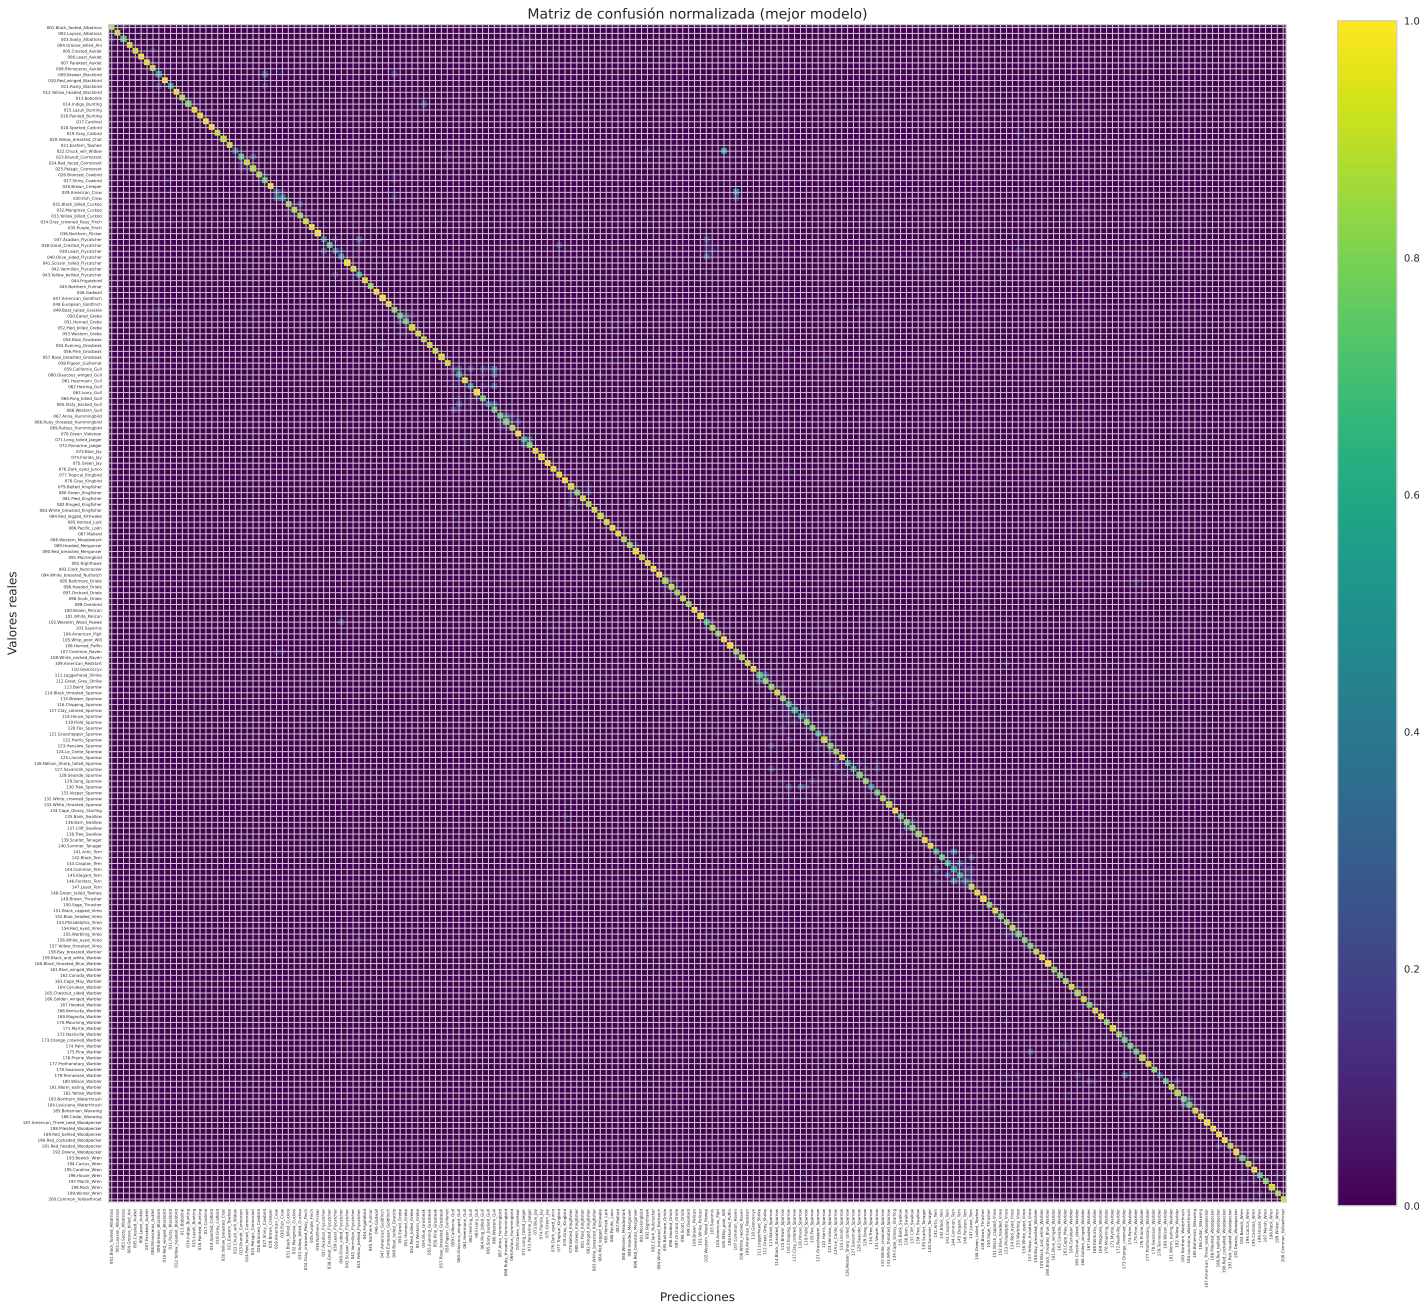


=== Entrenando modelo con embedding: SigLIPv2, dataset: FGVC-Aircraft ===
Train: (3334, 770), Val: (3333, 770), Test: (3333, 770)
                    Description  \
0                    Session id   
1                        Target   
2                   Target type   
3                Target mapping   
4           Original data shape   
5        Transformed data shape   
6   Transformed train set shape   
7    Transformed test set shape   
8              Numeric features   
9          Categorical features   
10                   Preprocess   
11              Imputation type   
12           Numeric imputation   
13       Categorical imputation   
14     Maximum one-hot encoding   
15              Encoding method   
16                Fix imbalance   
17         Fix imbalance method   
18               Fold Generator   
19                  Fold Number   
20                     CPU Jobs   
21                      Use GPU   
22               Log Experiment   
23              Experiment Na

                                  Model  Accuracy     AUC  Recall   Prec.  \
mlp                      MLP Classifier    0.7666  0.9962  0.7666  0.7708   
lr                  Logistic Regression    0.7618  0.9955  0.7618  0.7706   
ridge                  Ridge Classifier    0.7531  0.0000  0.7531  0.7511   
et               Extra Trees Classifier    0.6790  0.9853  0.6790  0.6791   
rf             Random Forest Classifier    0.6748  0.9854  0.6748  0.6763   
knn              K Neighbors Classifier    0.4845  0.8237  0.4845  0.5166   
svm                 SVM - Linear Kernel    0.4692  0.0000  0.4692  0.4771   
rbfsvm              SVM - Radial Kernel    0.4602  0.9906  0.4602  0.4707   
nb                          Naive Bayes    0.0201  0.0000  0.0201  0.0004   
qda     Quadratic Discriminant Analysis    0.0138  0.5019  0.0138  0.0003   
dt             Decision Tree Classifier    0.0102  0.0000  0.0102  0.0001   
ada                Ada Boost Classifier    0.0102  0.0000  0.0102  0.0001   

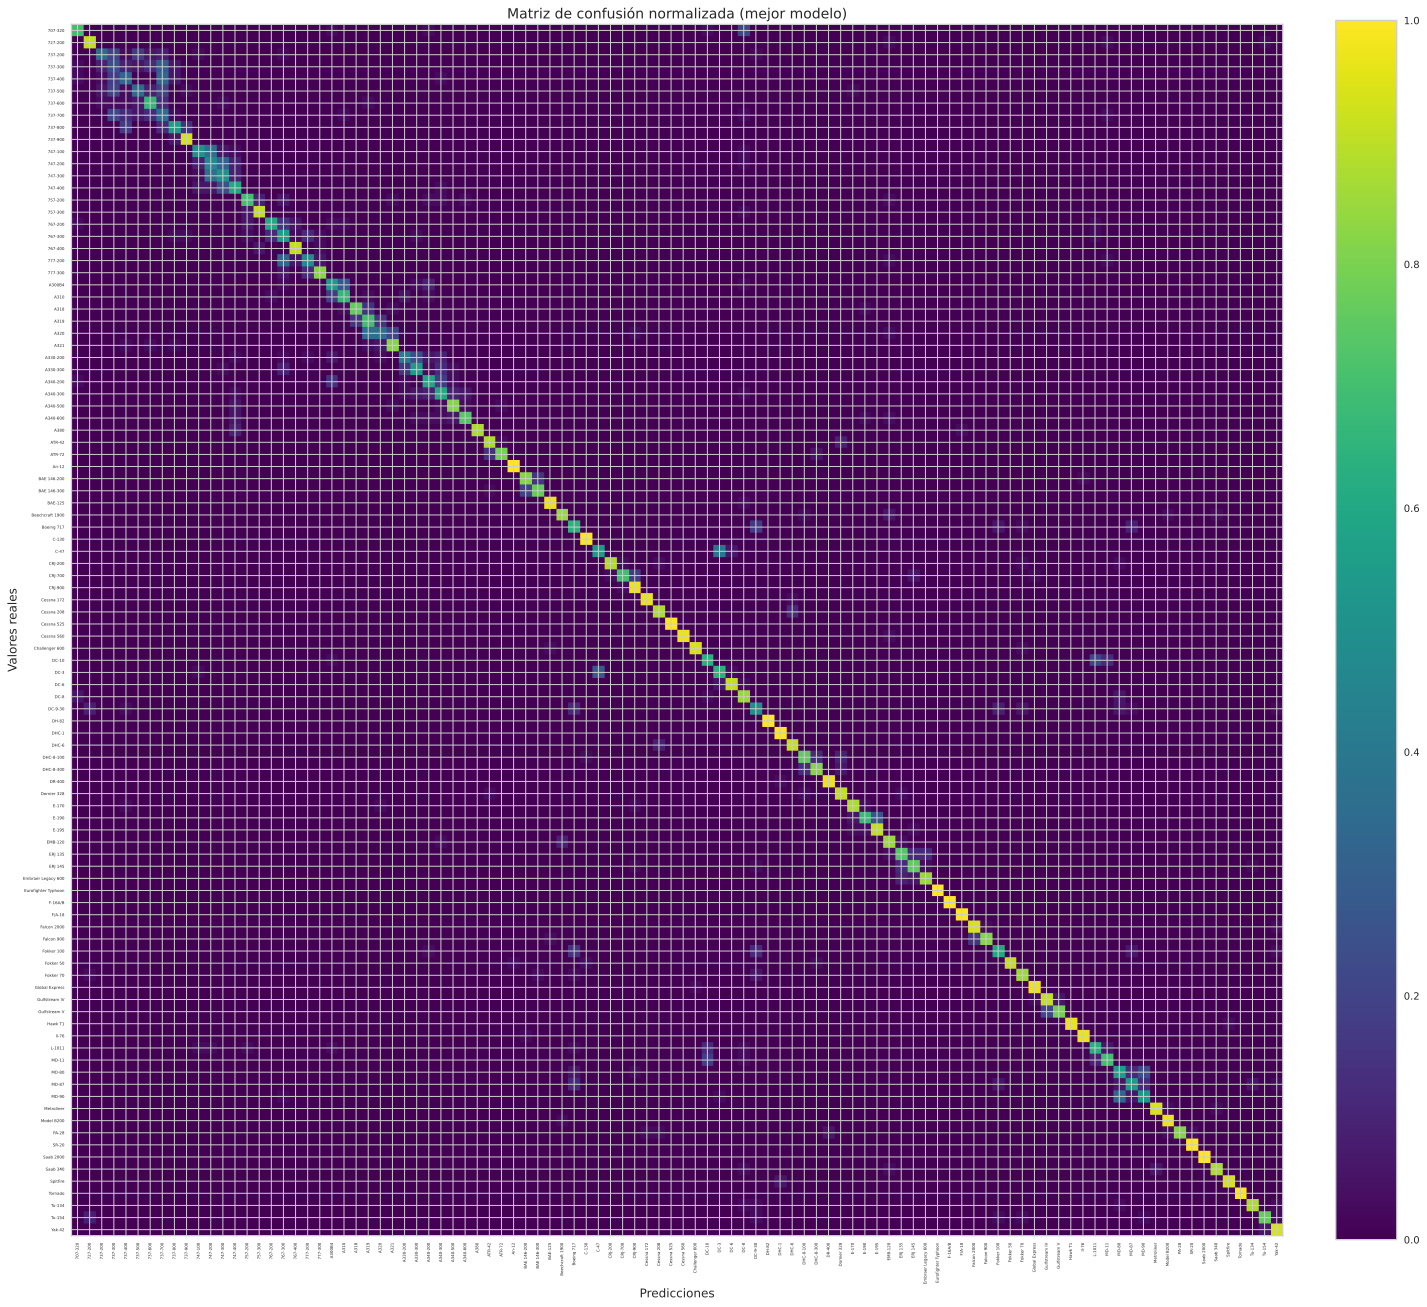


=== Entrenando modelo con embedding: SigLIPv2, dataset: NABirds ===
Train: (19314, 770), Val: (4615, 770), Test: (24633, 770)
                    Description  \
0                    Session id   
1                        Target   
2                   Target type   
3                Target mapping   
4           Original data shape   
5        Transformed data shape   
6   Transformed train set shape   
7    Transformed test set shape   
8              Numeric features   
9          Categorical features   
10                   Preprocess   
11              Imputation type   
12           Numeric imputation   
13       Categorical imputation   
14     Maximum one-hot encoding   
15              Encoding method   
16                Fix imbalance   
17         Fix imbalance method   
18               Fold Generator   
19                  Fold Number   
20                     CPU Jobs   
21                      Use GPU   
22               Log Experiment   
23              Experiment Name  

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.7792  0.9989  0.7792  0.8012   
ridge                  Ridge Classifier    0.7220  0.0000  0.7220  0.7605   
mlp                      MLP Classifier    0.6698  0.9978  0.6698  0.7056   
rf             Random Forest Classifier    0.6462  0.9848  0.6462  0.6657   
et               Extra Trees Classifier    0.6436  0.9835  0.6436  0.6654   
svm                 SVM - Linear Kernel    0.1244  0.0000  0.1244  0.1128   
knn              K Neighbors Classifier    0.1027  0.5645  0.1027  0.0418   
rbfsvm              SVM - Radial Kernel    0.1012  0.8241  0.1012  0.0369   
nb                          Naive Bayes    0.0026  0.0000  0.0026  0.0000   
dt             Decision Tree Classifier    0.0026  0.0000  0.0026  0.0000   
qda     Quadratic Discriminant Analysis    0.0026  0.5000  0.0026  0.0000   
lda        Linear Discriminant Analysis    0.0026  0.0000  0.0026  0.0000   


=== Entrenando modelo con embedding: SigLIPv2, dataset: Oxford 102 Flower ===
Train: (6149, 770), Val: (1020, 770), Test: (1020, 770)
                    Description  \
0                    Session id   
1                        Target   
2                   Target type   
3                Target mapping   
4           Original data shape   
5        Transformed data shape   
6   Transformed train set shape   
7    Transformed test set shape   
8              Numeric features   
9          Categorical features   
10                   Preprocess   
11              Imputation type   
12           Numeric imputation   
13       Categorical imputation   
14     Maximum one-hot encoding   
15              Encoding method   
16                Fix imbalance   
17         Fix imbalance method   
18               Fold Generator   
19                  Fold Number   
20                     CPU Jobs   
21                      Use GPU   
22               Log Experiment   
23              Experimen

                                  Model  Accuracy     AUC  Recall   Prec.  \
mlp                      MLP Classifier    0.9941  0.9997  0.9941  0.9945   
lr                  Logistic Regression    0.9931  1.0000  0.9931  0.9938   
ridge                  Ridge Classifier    0.9892  0.0000  0.9892  0.9903   
rf             Random Forest Classifier    0.9833  0.9997  0.9833  0.9848   
et               Extra Trees Classifier    0.9833  0.9993  0.9833  0.9848   
svm                 SVM - Linear Kernel    0.9814  0.0000  0.9814  0.9836   
knn              K Neighbors Classifier    0.7559  0.8839  0.7559  0.7223   
rbfsvm              SVM - Radial Kernel    0.6765  0.9996  0.6765  0.6077   
dummy                  Dummy Classifier    0.0098  0.0000  0.0098  0.0001   
nb                          Naive Bayes    0.0098  0.0000  0.0098  0.0001   
dt             Decision Tree Classifier    0.0098  0.0000  0.0098  0.0001   
qda     Quadratic Discriminant Analysis    0.0098  0.0000  0.0098  0.0001   

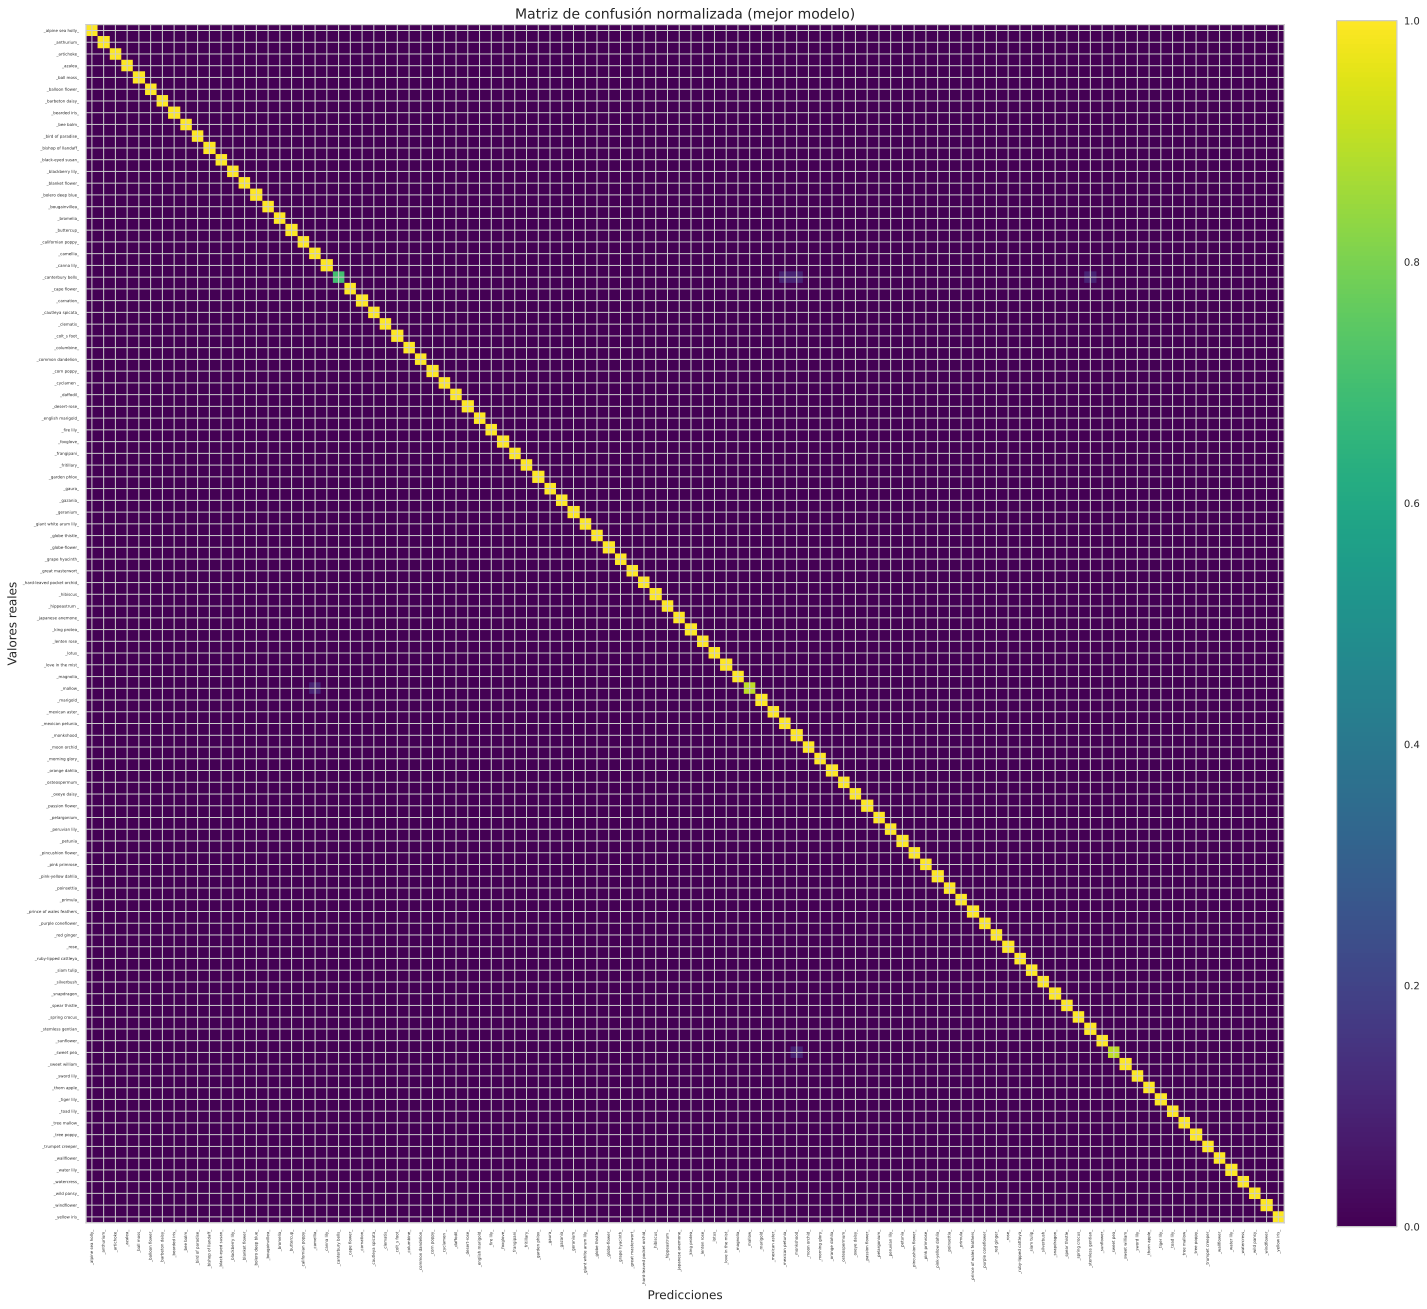


=== Entrenando modelo con embedding: SigLIPv2, dataset: Stanford Cars ===
Train: (6598, 770), Val: (1546, 770), Test: (8041, 770)
                    Description  \
0                    Session id   
1                        Target   
2                   Target type   
3                Target mapping   
4           Original data shape   
5        Transformed data shape   
6   Transformed train set shape   
7    Transformed test set shape   
8              Numeric features   
9          Categorical features   
10                   Preprocess   
11              Imputation type   
12           Numeric imputation   
13       Categorical imputation   
14     Maximum one-hot encoding   
15              Encoding method   
16                Fix imbalance   
17         Fix imbalance method   
18               Fold Generator   
19                  Fold Number   
20                     CPU Jobs   
21                      Use GPU   
22               Log Experiment   
23              Experiment Na

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.9528  0.9998  0.9528  0.9567   
mlp                      MLP Classifier    0.9495  0.9997  0.9495  0.9544   
ridge                  Ridge Classifier    0.9444  0.0000  0.9444  0.9496   
et               Extra Trees Classifier    0.9366  0.9984  0.9366  0.9379   
rf             Random Forest Classifier    0.9308  0.9990  0.9308  0.9347   
svm                 SVM - Linear Kernel    0.7930  0.0000  0.7930  0.7587   
knn              K Neighbors Classifier    0.4922  0.7727  0.4922  0.4594   
rbfsvm              SVM - Radial Kernel    0.4230  0.9994  0.4230  0.3270   
dummy                  Dummy Classifier    0.0058  0.0000  0.0058  0.0000   
ada                Ada Boost Classifier    0.0052  0.0000  0.0052  0.0000   
nb                          Naive Bayes    0.0032  0.0000  0.0032  0.0000   
dt             Decision Tree Classifier    0.0032  0.0000  0.0032  0.0000   

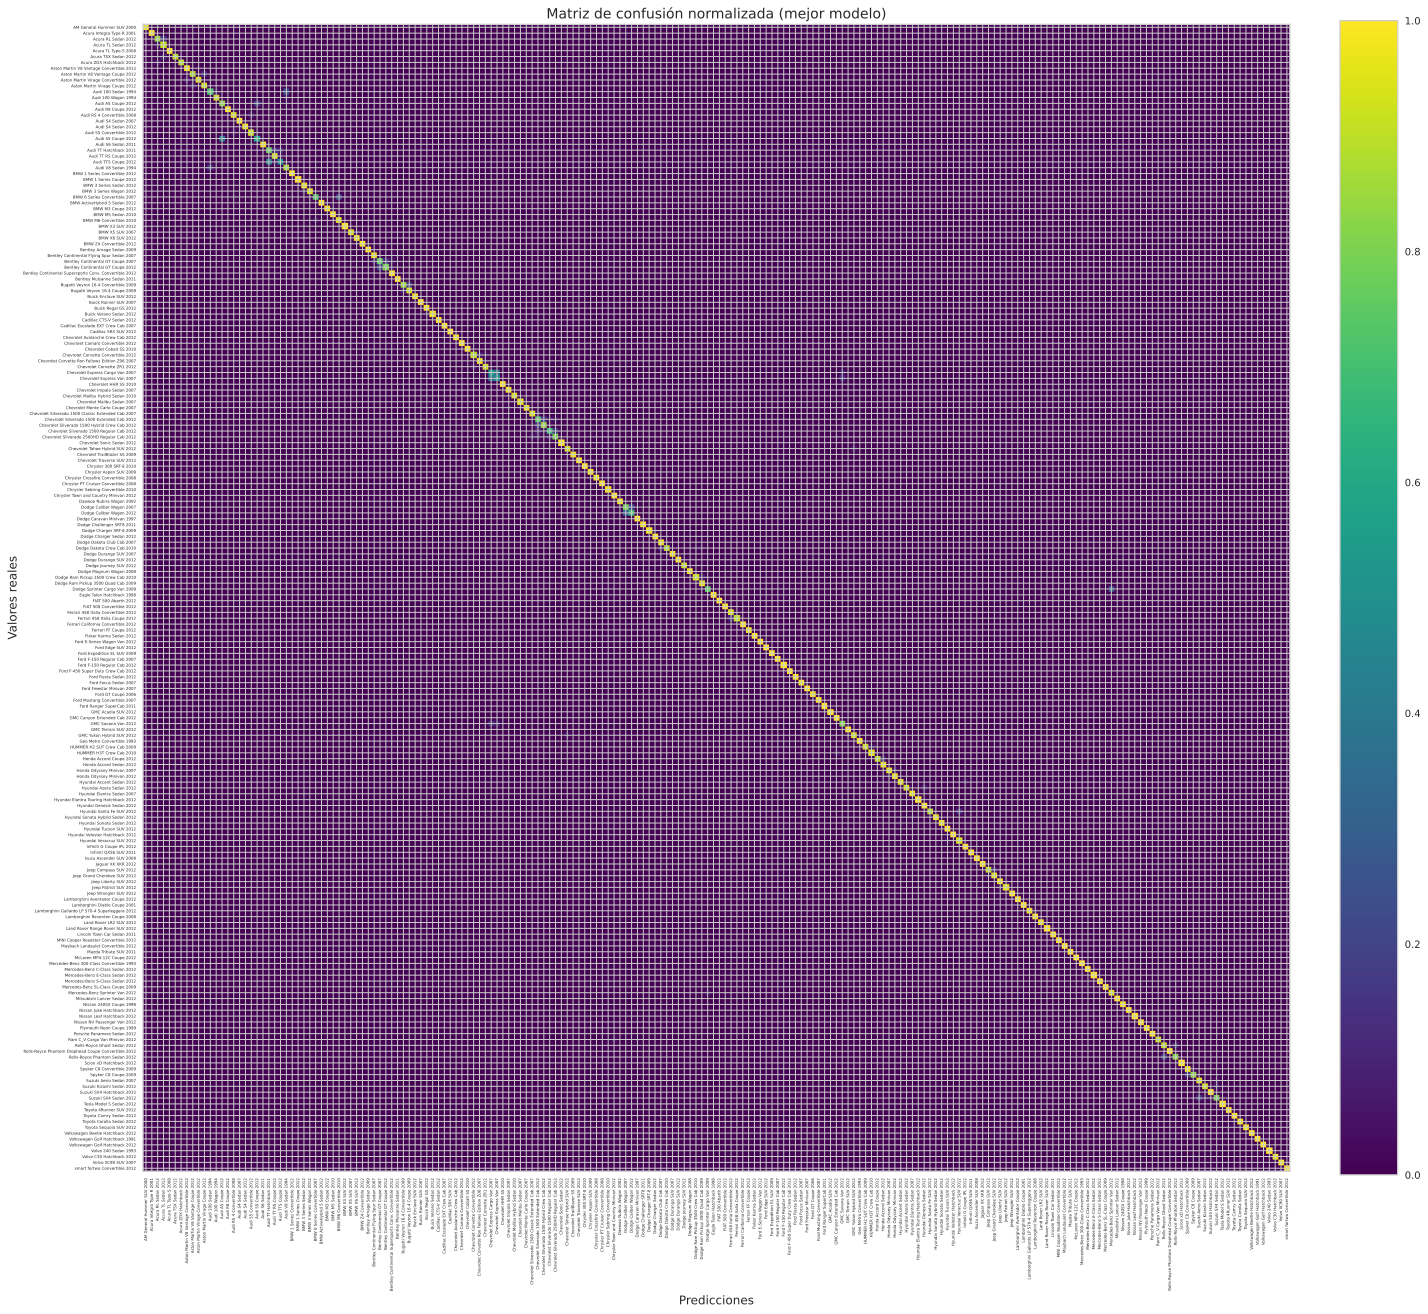


=== Entrenando modelo con embedding: SigLIPv2, dataset: Stanford Dogs ===
Train: (9600, 770), Val: (2400, 770), Test: (8580, 770)
                    Description  \
0                    Session id   
1                        Target   
2                   Target type   
3                Target mapping   
4           Original data shape   
5        Transformed data shape   
6   Transformed train set shape   
7    Transformed test set shape   
8              Numeric features   
9          Categorical features   
10                   Preprocess   
11              Imputation type   
12           Numeric imputation   
13       Categorical imputation   
14     Maximum one-hot encoding   
15              Encoding method   
16                Fix imbalance   
17         Fix imbalance method   
18               Fold Generator   
19                  Fold Number   
20                     CPU Jobs   
21                      Use GPU   
22               Log Experiment   
23              Experiment Na

                                  Model  Accuracy     AUC  Recall   Prec.  \
lr                  Logistic Regression    0.8362  0.9976  0.8362  0.8423   
mlp                      MLP Classifier    0.8133  0.9970  0.8133  0.8199   
ridge                  Ridge Classifier    0.8075  0.0000  0.8075  0.8188   
rf             Random Forest Classifier    0.7467  0.9869  0.7467  0.7554   
et               Extra Trees Classifier    0.7354  0.9846  0.7354  0.7428   
svm                 SVM - Linear Kernel    0.5938  0.0000  0.5938  0.6991   
knn              K Neighbors Classifier    0.4400  0.7833  0.4400  0.4888   
rbfsvm              SVM - Radial Kernel    0.3713  0.9878  0.3713  0.3762   
nb                          Naive Bayes    0.0167  0.0000  0.0167  0.0003   
qda     Quadratic Discriminant Analysis    0.0092  0.5004  0.0092  0.0008   
dummy                  Dummy Classifier    0.0083  0.0000  0.0083  0.0001   
dt             Decision Tree Classifier    0.0083  0.0000  0.0083  0.0001   

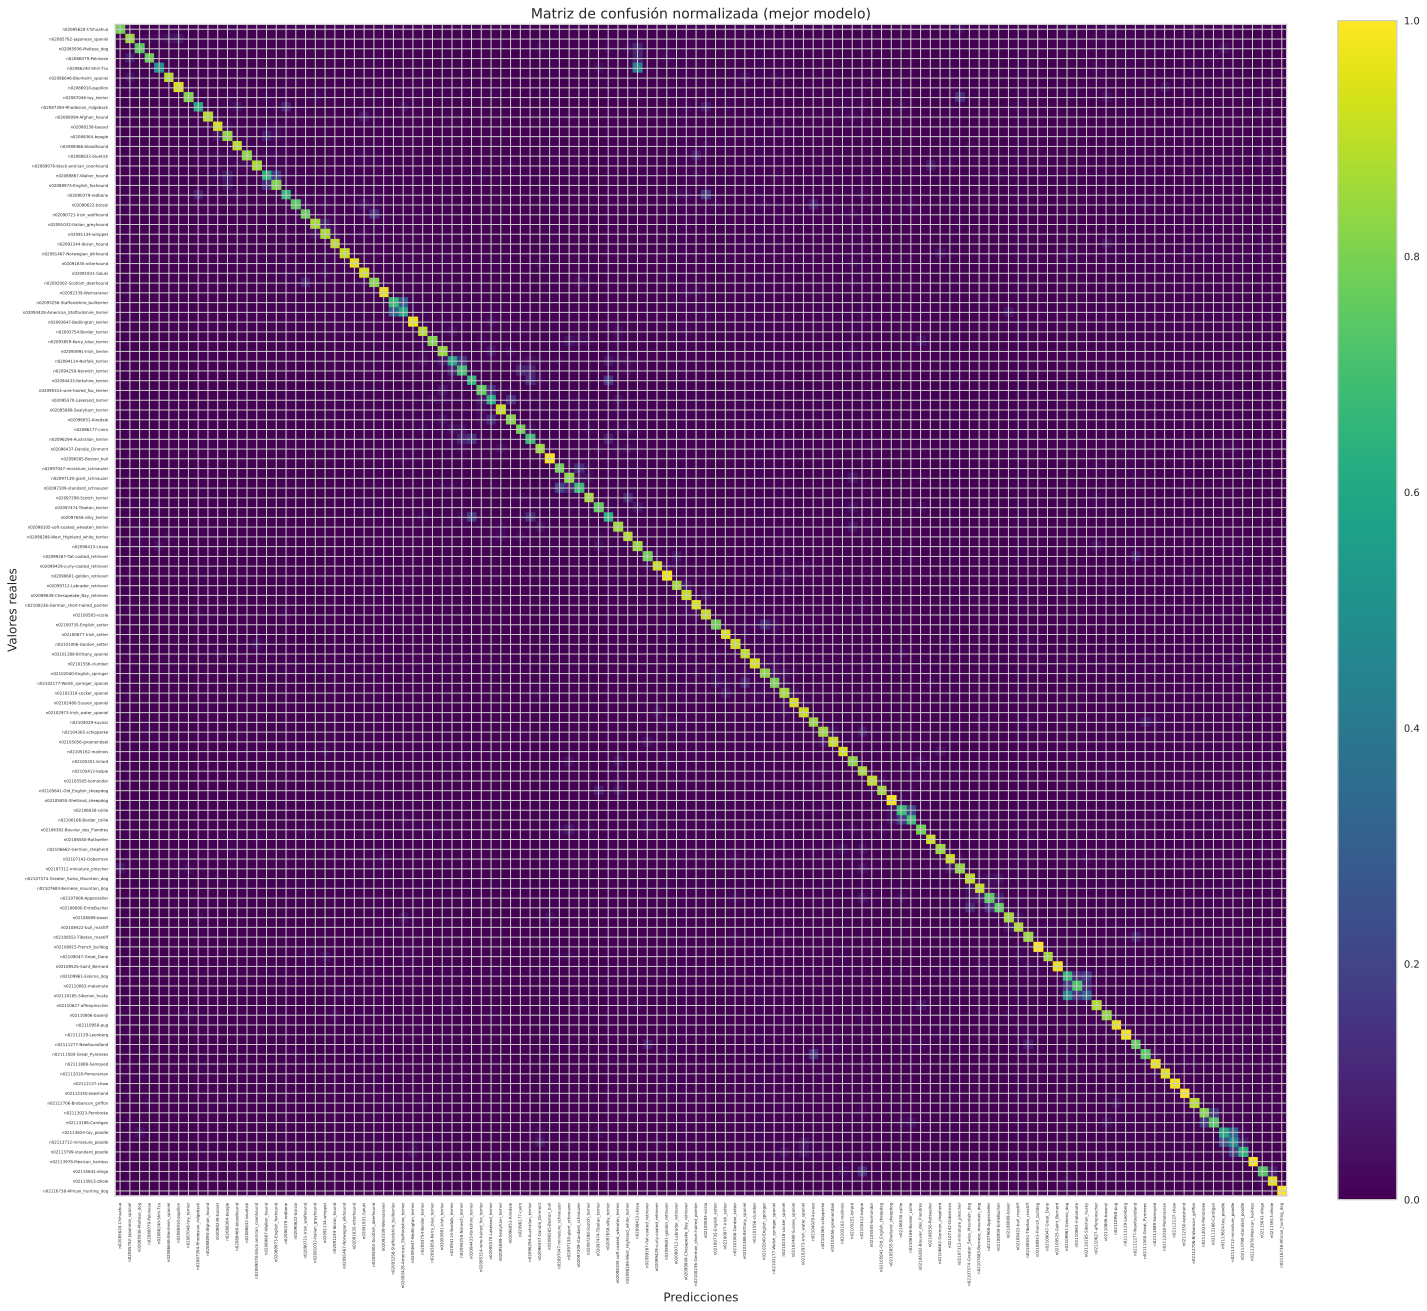

In [20]:
# embeddings = "SigLIPv2"
# datasets = sorted({key[1] for key in dataframes.keys()})

# for dataset in datasets:
#     required_splits = ['train', 'validation', 'test']
#     if all((embedding, dataset, split) in dataframes for split in required_splits):
#         df_train = dataframes[(embedding, dataset, 'train')]
#         df_val = dataframes[(embedding, dataset, 'validation')]
#         df_test = dataframes[(embedding, dataset, 'test')]
            
#         entrenar_modelo_balanceado(embedding, dataset, df_train, df_val, df_test)
#     else:
#         print(f"Saltando {embedding} / {dataset}, faltan splits")